# Forecasting Spanish Electricity Prices: Leveraging Machine Learning in a Deregulated Market

In the wake of energy market deregulation, machine learning has become a pivotal tool for accurate electricity price and load forecasting. With intricate variables like supply-demand dynamics, weather patterns, and regulations at play, traditional methods fall short. Machine learning's capacity to analyze vast datasets, identify hidden patterns, and adapt to changing conditions addresses these challenges effectively. By providing real-time insights, it empowers stakeholders to make informed decisions, manage risks, and navigate the volatile energy landscape with confidence.

Using a multitude of different approaches such as Prophet, XGBoost, and various deep learning architectures implemented in Tensorflow, we will determine the best practices for predicting energy prices on this particular dataset. This notebook contains the analysis of seperate but related time-series datasets featuring hourly data over the 4 year period between 2015 and 2019. These are listed below:

 - ***energy_dataset.csv***
    - Contains information regarding the sources, load, and prices of electricity in Spain. This dataset containts our target variable, _'price actual'_, which is given in units of &euro;/MWh.<br>
 - ***weather_dataset.csv***
    - Contains comprehensive hourly weather information for 5 of the largest cities in Spain (Madrid, Bilbao, Barcelona, Seville, and Valencia).  

The goal of this notebook will focus primarily on the prediction of future electricity prices based on past data. Starting with Prophet, we decompose our prices information into sub trends which can be analyzed and used for feature engineering in other processes. Next, we move on to XGBoost, where we implement a model to forecast the price of electricity at a particular hour (or set of hours) based upon previous hourly information. Finally, we will explore a multitude of time-series neural network arcitectures such as LSTMs and CNNs to forecast hourly prices similarly to what we did with XGBoost. While the main purpose will be to forecast prices, we will also explore other interesting topics such as load forecasting and drivers of energy prices. 

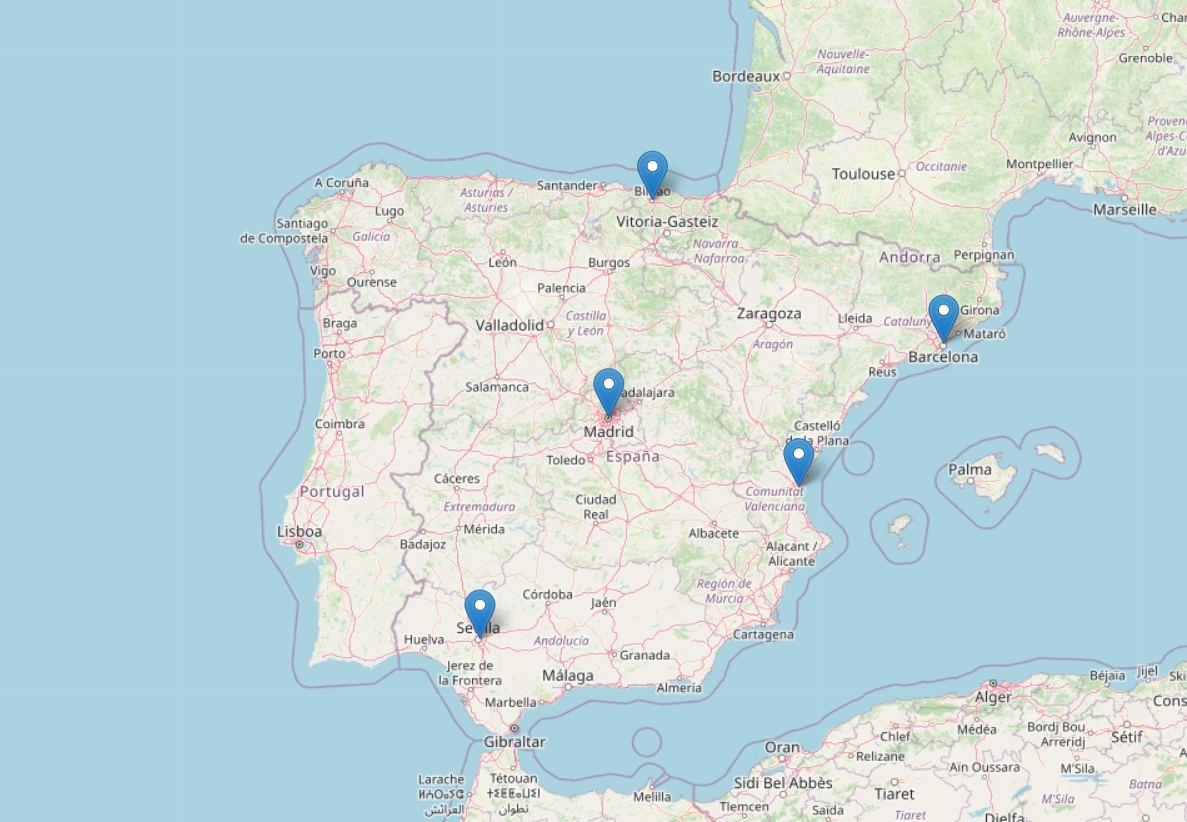

In [135]:
from IPython.display import Image
Image(filename='spain-map.png')

Featured above is a map of the 5 cities which we have weather information for. As stated previously, these are Barcelona, Bilbao, Madrid, Seville, and Valencia. 

In [216]:
# Importing required packages
import pandas as pd
import seaborn as sns
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import tensorflow as tf
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

# Data Importing and Cleaning

## Energy Dataset

In [137]:
# Reading data
energy_df = pd.read_csv('data/energy_dataset.csv', index_col='time')

# Converting index to datetime format
energy_df.index = pd.to_datetime(energy_df.index, utc=True)

In [138]:
energy_df.head()

generation biomass  \
time                                            
2014-12-31 23:00:00+00:00               447.0   
2015-01-01 00:00:00+00:00               449.0   
2015-01-01 01:00:00+00:00               448.0   
2015-01-01 02:00:00+00:00               438.0   
2015-01-01 03:00:00+00:00               428.0   

                           generation fossil brown coal/lignite  \
time                                                              
2014-12-31 23:00:00+00:00                                 329.0   
2015-01-01 00:00:00+00:00                                 328.0   
2015-01-01 01:00:00+00:00                                 323.0   
2015-01-01 02:00:00+00:00                                 254.0   
2015-01-01 03:00:00+00:00                                 187.0   

                           generation fossil coal-derived gas  \
time                                                            
2014-12-31 23:00:00+00:00                                 0.0   
2015-01-01 00:00:00+00:00                                 0.0   
2015-01-01 01:00:00+00:00                                 0.0   
2015-01-01 02:00:00+00:00                                 0.0   
2015-01-01 03:00:00+00:00                                 0.0   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2014-12-31 23:00:00+00:00                 4844.0                       4821.0   
2015-01-01 00:00:00+00:00                 5196.0                       4755.0   
2015-01-01 01:00:00+00:00                 4857.0                       4581.0   
2015-01-01 02:00:00+00:00                 4314.0                       4131.0   
2015-01-01 03:00:00+00:00                 4130.0                       3840.0   

                           generation fossil oil  generation fossil oil shale  \
time                                                                            
2014-12-31 23:00:00+00:00                  162.0                          0.0   
2015-01-01 00:00:00+00:00                  158.0                          0.0   
2015-01-01 01:00:00+00:00                  157.0                          0.0   
2015-01-01 02:00:00+00:00                  160.0                          0.0   
2015-01-01 03:00:00+00:00                  156.0                          0.0   

                           generation fossil peat  generation geothermal  \
time                                                                       
2014-12-31 23:00:00+00:00                     0.0                    0.0   
2015-01-01 00:00:00+00:00                     0.0                    0.0   
2015-01-01 01:00:00+00:00                     0.0                    0.0   
2015-01-01 02:00:00+00:00                     0.0                    0.0   
2015-01-01 03:00:00+00:00                     0.0                    0.0   

                           generation hydro pumped storage aggregated  \
time                                                                    
2014-12-31 23:00:00+00:00                                         NaN   
2015-01-01 00:00:00+00:00                                         NaN   
2015-01-01 01:00:00+00:00                                         NaN   
2015-01-01 02:00:00+00:00                                         NaN   
2015-01-01 03:00:00+00:00                                         NaN   

                           generation hydro pumped storage consumption  \
time                                                                     
2014-12-31 23:00:00+00:00                                        863.0   
2015-01-01 00:00:00+00:00                                        920.0   
2015-01-01 01:00:00+00:00                                       1164.0   
2015-01-01 02:00:00+00:00                                       1503.0   
2015-01-01 03:00:00+00:00                                       1826.0   

                           generation hydro run-of-river 

In [139]:
energy_df.describe().round(2)

generation biomass  generation fossil brown coal/lignite  \
count            35045.00                              35046.00   
mean               383.51                                448.06   
std                 85.35                                354.57   
min                  0.00                                  0.00   
25%                333.00                                  0.00   
50%                367.00                                509.00   
75%                433.00                                757.00   
max                592.00                                999.00   

       generation fossil coal-derived gas  generation fossil gas  \
count                             35046.0               35046.00   
mean                                  0.0                5622.74   
std                                   0.0                2201.83   
min                                   0.0                   0.00   
25%                                   0.0                4126.00   
50%                                   0.0                4969.00   
75%                                   0.0                6429.00   
max                                   0.0               20034.00   

       generation fossil hard coal  generation fossil oil  \
count                     35046.00               35045.00   
mean                       4256.07                 298.32   
std                        1961.60                  52.52   
min                           0.00                   0.00   
25%                        2527.00                 263.00   
50%                        4474.00                 300.00   
75%                        5838.75                 330.00   
max                        8359.00                 449.00   

       generation fossil oil shale  generation fossil peat  \
count                      35046.0                 35046.0   
mean                           0.0                     0.0   
std                            0.0                     0.0   
min                            0.0                     0.0   
25%                            0.0                     0.0   
50%                            0.0                     0.0   
75%                            0.0                     0.0   
max                            0.0                     0.0   

       generation geothermal  generation hydro pumped storage aggregated  \
count                35046.0                                         0.0   
mean                     0.0                                         NaN   
std                      0.0                                         NaN   
min                      0.0                                         NaN   
25%                      0.0                                         NaN   
50%                      0.0                                         NaN   
75%                      0.0                                         NaN   
max                      0.0                                         NaN   

       generation hydro pumped storage consumption  \
count                                     35045.00   
mean                                        475.58   
std                                         792.41   
min                                           0.00   
25%                                           0.00   
50%                                          68.00   
75%                                         616.00   
max                                        4523.00   

       generation hydro run-of-river and poundage  \
count                                    35045.00   
mean                                       972.12   
std                                        400.78   
min                                          0.00   
25%                                        637.00   
50%                                        906.00   
75%                                       1250.00   
max                                       2000.00   

       generation hydro water r

From the description of the dataframe, we find that a number of columns have mean and maximum values of 0 This is likely indicative that all row values of these columns are 0. To remove these extraneous columns we will drop any columns with all zero/NaN values. In addition, we will remove columns which include forecasting data, as we would like to make our own forecasts. This returns a dataset with only relevant columns.

In [140]:
# Select columns where the max is not equal to 0 or NaN
column_max = energy_df.max()
columns_to_keep = column_max[(column_max != 0) & (~column_max.isna())].index
energy_df = energy_df[columns_to_keep]

# dropping forecast columns
forecast_cols = [col for col in energy_df.columns if 'forecast' in col]
energy_df = energy_df.drop(columns=forecast_cols)

We now check for null and duplicate values in the remaining columns. Upon finding the null values, we will interpolate them to obtain a dataset entirely populated by numeric data.

In [141]:
# Checking null values
energy_df.isnull().sum()

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

In [142]:
# Checking duplicates
print("Number of duplicates in energy_df:", energy_df.duplicated().sum())

Number of duplicates in energy_df: 0


we see that many of our columns have null values and none of our columns have duplicates. To fix our null values, we will them using linear interpolation.

In [143]:
# Interpolating null values
energy_df.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

# Verifying that null values are no longer present
energy_df.isnull().sum(axis=0)

generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
total load actual                              0
price day ahead                                0
price actual                                   0
dtype: int64

Finally, we check for outliers within the energy_df. We do so by normalizing our data and plotting each column as a boxplot. This can be seen below.

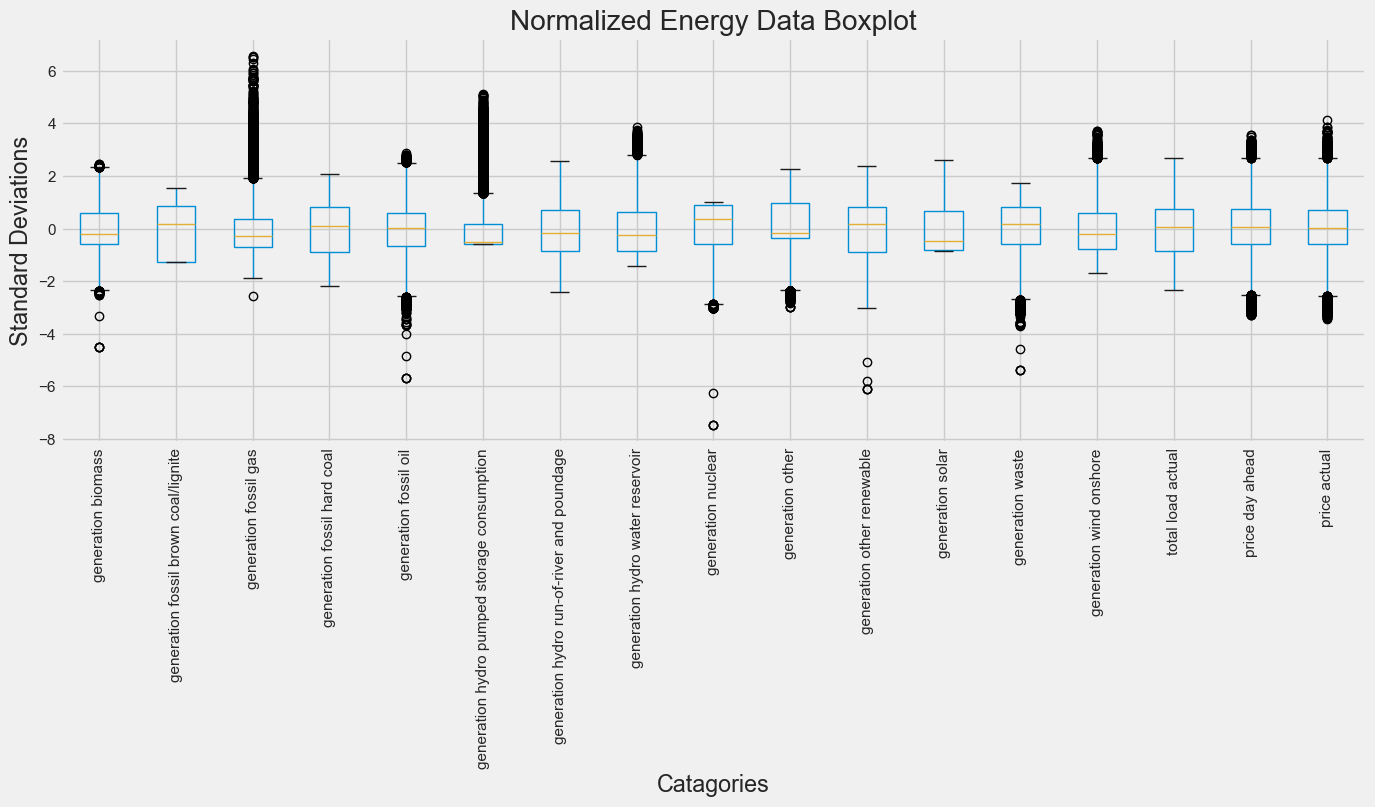

In [144]:
# Normalizing columns
normalized_energy_df = (energy_df - energy_df.mean()) / energy_df.std()

# Creating and labelling boxplot
normalized_energy_df.boxplot(figsize = (15,5))
plt.title('Normalized Energy Data Boxplot')
plt.ylabel('Standard Deviations')
plt.xlabel('Catagories')
plt.xticks(rotation = 90)
plt.show()

From our boxplot, we can see that there are no blatant outliers massively outside a reasonable range of data. Therefor we can can reasonably conclude that all data falls within an acceptable range of values.

With no duplicates, null values or outliers visible within the energy_df, we can rest assured that our dataframe is cleaned for future use in the training of ML models.

## Weather Dataset

In [145]:
# Uploading weather dataset
weather_df = pd.read_csv('data/weather_features.csv', index_col= 'dt_iso')

# Correctly formatting the index column
weather_df.index = pd.to_datetime(weather_df.index, utc=True, infer_datetime_format=True)

# Renaming index for simplicity
weather_df.index.name = 'time'

C:\Users\StephenBodley\AppData\Local\Temp\ipykernel_21244\454348902.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  weather_df.index = pd.to_datetime(weather_df.index, utc=True, infer_datetime_format=True)


In [146]:
weather_df.head()

city_name     temp  temp_min  temp_max  pressure  \
time                                                                         
2014-12-31 23:00:00+00:00  Valencia  270.475   270.475   270.475      1001   
2015-01-01 00:00:00+00:00  Valencia  270.475   270.475   270.475      1001   
2015-01-01 01:00:00+00:00  Valencia  269.686   269.686   269.686      1002   
2015-01-01 02:00:00+00:00  Valencia  269.686   269.686   269.686      1002   
2015-01-01 03:00:00+00:00  Valencia  269.686   269.686   269.686      1002   

                           humidity  wind_speed  wind_deg  rain_1h  rain_3h  \
time                                                                          
2014-12-31 23:00:00+00:00        77           1        62      0.0      0.0   
2015-01-01 00:00:00+00:00        77           1        62      0.0      0.0   
2015-01-01 01:00:00+00:00        78           0        23      0.0      0.0   
2015-01-01 02:00:00+00:00        78           0        23      0.0      0.0   
2015-01-01 03:00:00+00:00        78           0        23      0.0      0.0   

                           snow_3h  clouds_all  weather_id weather_main  \
time                                                                      
2014-12-31 23:00:00+00:00      0.0           0         800        clear   
2015-01-01 00:00:00+00:00      0.0           0         800        clear   
2015-01-01 01:00:00+00:00      0.0           0         800        clear   
2015-01-01 02:00:00+00:00      0.0           0         800        clear   
2015-01-01 03:00:00+00:00      0.0           0         800        clear   

                          weather_description weather_icon  
time                                                        
2014-12-31 23:00:00+00:00        sky is clear          01n  
2015-01-01 00:00:00+00:00        sky is clear          01n  
2015-01-01 01:00:00+00:00        sky is clear          01n  
2015-01-01 02:00:00+00:00        sky is clear          01n  
2015-01-01 03:00:00+00:00        sky is clear          01n

In [147]:
weather_df.describe().round(2)

temp   temp_min   temp_max    pressure   humidity  wind_speed  \
count  178396.00  178396.00  178396.00   178396.00  178396.00   178396.00   
mean      289.62     288.33     291.09     1069.26      68.42        2.47   
std         8.03       7.96       8.61     5969.63      21.90        2.10   
min       262.24     262.24     262.24        0.00       0.00        0.00   
25%       283.67     282.48     284.65     1013.00      53.00        1.00   
50%       289.15     288.15     290.15     1018.00      72.00        2.00   
75%       295.15     293.73     297.15     1022.00      87.00        4.00   
max       315.60     315.15     321.15  1008371.00     100.00      133.00   

        wind_deg    rain_1h    rain_3h    snow_3h  clouds_all  weather_id  
count  178396.00  178396.00  178396.00  178396.00   178396.00   178396.00  
mean      166.59       0.08       0.00       0.00       25.07      759.83  
std       116.61       0.40       0.01       0.22       30.77      108.73  
min         0.00       0.00       0.00       0.00        0.00      200.00  
25%        55.00       0.00       0.00       0.00        0.00      800.00  
50%       177.00       0.00       0.00       0.00       20.00      800.00  
75%       270.00       0.00       0.00       0.00       40.00      801.00  
max       360.00      12.00       2.32      21.50      100.00      804.00

From the dataframe description, a number of things stand out. These are listed below:

* The ***rain_3h*** column doesn't make sense. The rain_1h and rain_3h columns specificy the amount of rainfall which occured in the previous 1 and 3 hours, respectively. The rain_3h column is erronous because it has a lower mean value than the rain_1h column. If it were correct, it would be larger. For this reason, we will drop the column. We now check for null values in the dataset.

* Some columns have extremely high standard deviations. Examining the ***pressure*** collumn especially, we find a massive standard deviation. We should examine the outliers of all columns in more detail.

* The maximum value in the ***wind_speed*** column, we find the maximum value to be very high. Becuase wind speeds are measured in $m/s$, the maximum value of $133~m/s$ equates to about $479~km/h$. This is on par with the fastest wind speeds ever recorded on earth [1], and higher than any wind speed over recorded in Spain, thus should be further examined.

To mitigate these concerns we start by dropping the ***rain_3h*** column.

In [148]:
# Dropping rain_3h column
weather_df.drop('rain_3h', axis=1, inplace=True)

### Examining Outliers

To examine outliers, we extract numerical columns and normalize them such that they can all be inspected on a boxplot with the same axis.

In [149]:
# Defining catagorical columns
drop_cols = ['weather_id', 'weather_main', 'weather_description', 'weather_icon', 'city_name']

# Creating new dataframe with all numerical columns
weather_df_nums = weather_df.drop(drop_cols, axis = 1)

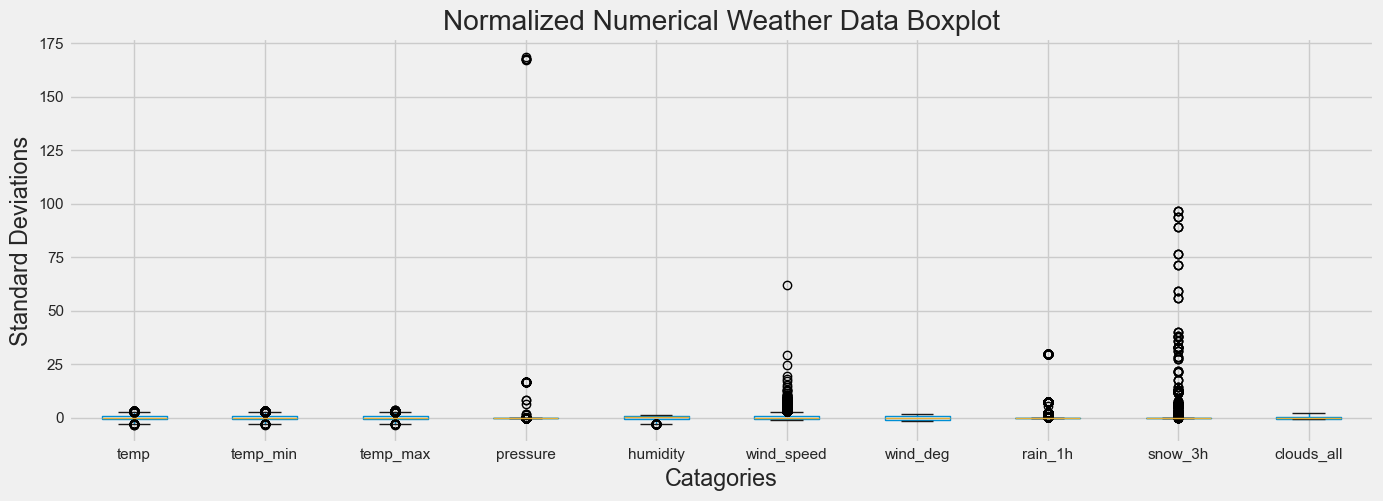

In [150]:
# Normalizing columns
normalized_df = (weather_df_nums - weather_df_nums.mean()) / weather_df_nums.std()

# Creating and labelling boxplot
normalized_df.boxplot(figsize = (15,5))
plt.title('Normalized Numerical Weather Data Boxplot')
plt.ylabel('Standard Deviations')
plt.xlabel('Catagories')
plt.show()

From the boxplot, we see that ***pressure, wind_speed, rain_1h, and snow_3h*** columns have extreme outliers. We will examine each of these individually, starting with ***pressure***.

In [151]:
def box_plotter(df, column, title="Data", xlabel=None, figsize=(15,3)):
    """
    Plots a box plot for a specified column of a dataframe.
    
    Parameters:
    - df (DataFrame): The dataframe containing the data.
    - column (str): The column name in the dataframe for which the box plot is to be generated.
    - title (str, optional): The title for the plot. Defaults to "Data".
    - xlabel (str, optional): The x-axis label. If not provided, the x-axis will have no specific label.
    - figsize (tuple, optional): Tuple indicating the width and height of the figure. Defaults to (15,3).
    
    Returns:
    - None: Displays the box plot.
    """
    
    plt.figure(figsize=figsize)
    sns.boxplot(x=df[column])
    plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    plt.show()


#### Pressure Data

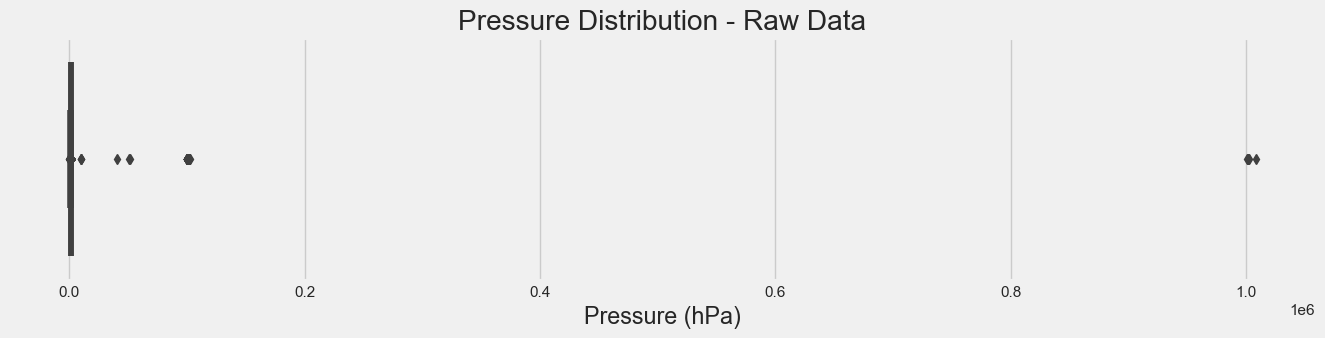

In [152]:
# Raw pressure data boxplot
box_plotter(weather_df, 'pressure', title='Pressure Distribution - Raw Data', xlabel='Pressure (hPa)')

From the pressure data, we see that there are some pretty extreme outliers. The highest recorded pressure is approximately $ 10^6~hPa$, which is a pressure similar to that at the bottom of the Mariana Trench [2]. This is obviously not a correct measurement.

Furthermore, the highest and lowest pressures ever recorded in Spain were $1051~hPa$  and $950~hPa$ respectively [3]. Beucause of this, we will ignore all data with pressure readings outside of this range.

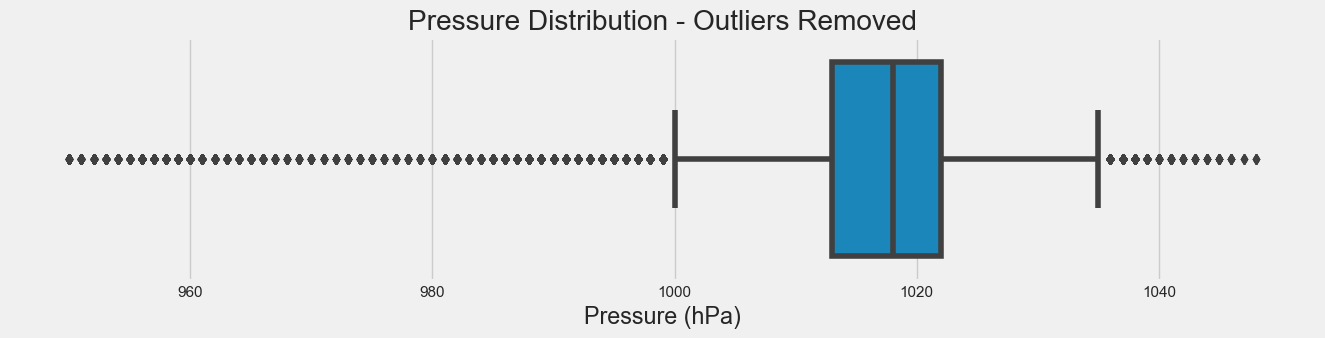

In [153]:
# Removing outliers
weather_df.loc[(weather_df['pressure'] > 1051) | (weather_df['pressure'] < 950), 'pressure'] = np.nan

# Replotting pressure data with outliers removed
box_plotter(weather_df, 'pressure', title='Pressure Distribution - Outliers Removed', xlabel='Pressure (hPa)')

#### Wind Speed

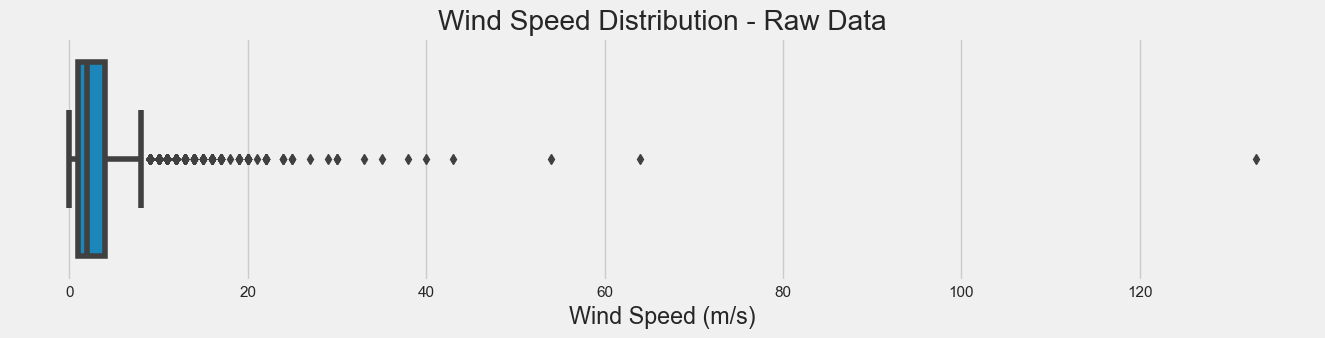

In [154]:
# Raw wind speed boxplot
box_plotter(weather_df, 'wind_speed', title='Wind Speed Distribution - Raw Data', xlabel='Wind Speed (m/s)')

We see that there is a pretty obvious outlier in this dataset. As previously mentioned, the  $133~m/s$ wind recorded would be faster than any wind speed recorded in Spain. For reference the highest wind speed ever recorded in Spain are approximately $200~km/h$ or about $56~m/s$. Because of this we will remove any data with wind speeds higher than $50~m/s$.

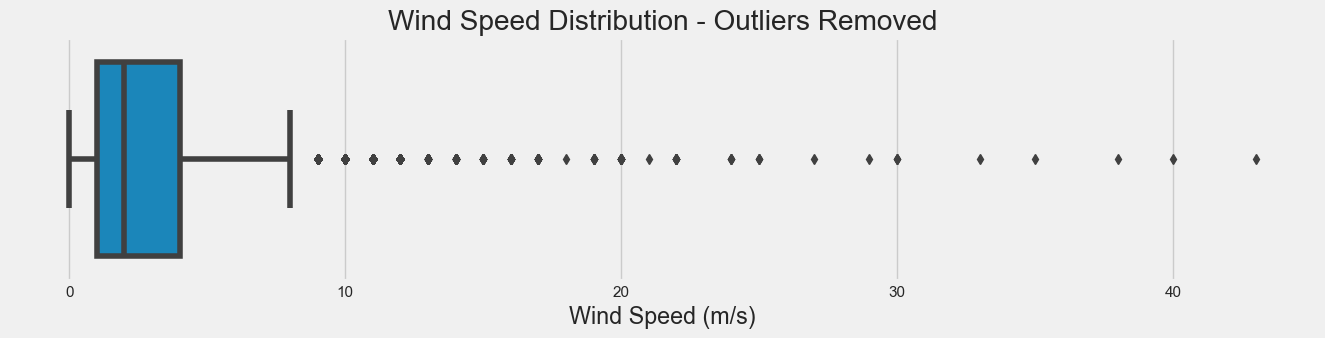

In [155]:
# Removing outliers
weather_df.loc[weather_df['wind_speed'] > 50, 'wind_speed'] = np.nan

# Replotting wind speed data with outliers removed
box_plotter(weather_df, 'wind_speed', title='Wind Speed Distribution - Outliers Removed', xlabel='Wind Speed (m/s)')


#### Rain 1h

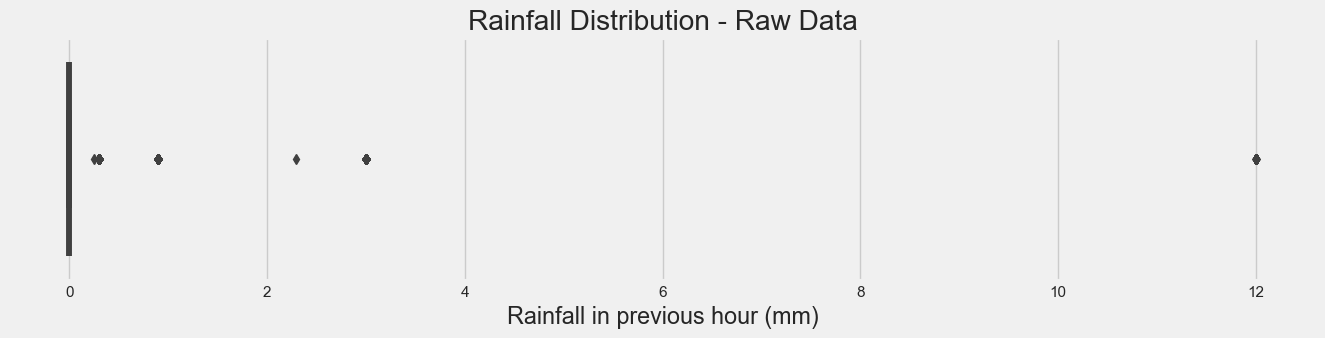

In [156]:
# Raw rainfall 1h boxplot
box_plotter(weather_df, 'rain_1h', title='Rainfall Distribution - Raw Data', xlabel='Rainfall in previous hour (mm)')

From research, it is clear that Spanish rainfalls of $100~mm/hour$ are possible [4]. Therefor, it is reasonable to assume that the $12~mm$ readings are entirely reasonable and do not need to be removed. Finally, we examing the ***snow_3h*** column.

#### Snow 3h

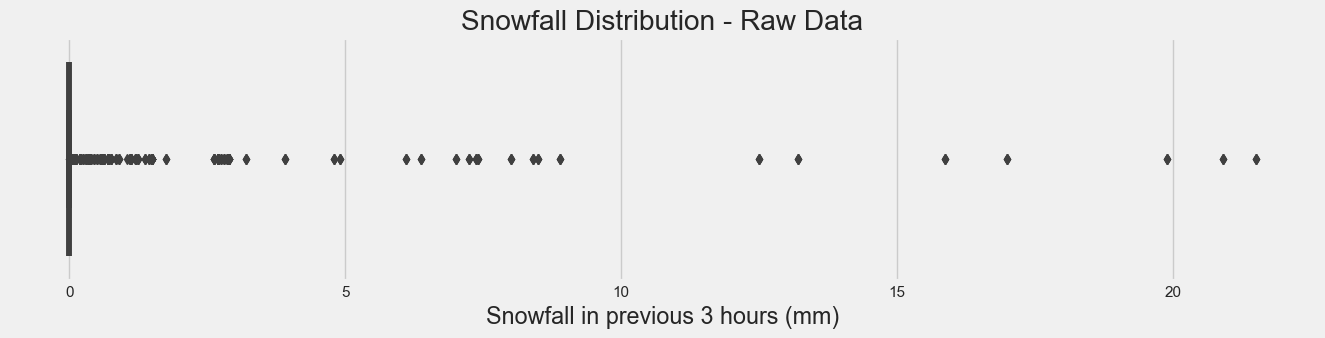

In [157]:
# Raw snowfall 3h boxplot 
box_plotter(weather_df, 'snow_3h', title='Snowfall Distribution - Raw Data', xlabel='Snowfall in previous 3 hours (mm)')

Examining the snowfall boxplot, it is reasonable to assume that $20~mm$ of snowfall in 3 hours is entirely possible. Therefor, we will not be removing any of the snowfall data.

### Formatting Weather Dataframe

Before the eventual joining of our weather and energy dataframes, we must ensure the following:

1. **The weather dataframe is formatted correctly.**  
Currently, the weather dataframe is formatted in a way which is not condusive to joining. The time series index is not continuous, and restarts its index each time there is a unique new entry in the **city_name** column. In order for a join to take place, there must be a single index time series value, with no repeat entries dependent on the city.

2. **There must be matching index values.**  
Upon correctly formatting, there must be matching index values between the weather and energy dataframes.

3. **There must be no missing or duplicated values in either dataframe.**  
We have already ensured that there are no missing values or duplicate values in the energy dataframe. We must now ensure the same for the weather dataframe.

4. **There is no redunancy within the columns.**  
Before formatting this dataframe, we should drop any redundant columns as it will be more difficult to do so upon formatting.

To begin this process, we will examine the duplicated values in the weather dataframe.

In [158]:
# Total number of duplicate values
num_duplicated = weather_df.duplicated(keep=False).sum()
print('The total number of duplicate values in weather_df is:', num_duplicated)

The total number of duplicate values in weather_df is: 14186


It appears there a high number of duplicate values within weather_df. We now examine the number entires for each city and see if this aligns with our energy_df

In [159]:
print('The length of the energy_df is:', len(energy_df))
print('\nThe lengths of data associated with each of the cities are:')

with_duplicates = weather_df['city_name'].value_counts()
print(with_duplicates)

The length of the energy_df is: 35064

The lengths of data associated with each of the cities are:
city_name
Madrid        36267
Bilbao        35951
Seville       35557
 Barcelona    35476
Valencia      35145
Name: count, dtype: int64


From this analysis, there appears to be many more entires for each the cities in weather_df than there are total entries in energy_df. We need to ensure that these numbers match up. The reason for this discrepancy could be due to the high number of duplicates in the weather_df. We will examine the  duplicates of the weather_df, subsetting on ***city_name*** and ***time***

In [160]:
# Creating boolean series which returns true when 'time' and 'city_name' value pairs are repeated.
duplicated_bool = weather_df.reset_index().duplicated(subset=['time', 'city_name'], keep=False)

In [161]:
# Subsetting weather dataframe based on boolean duplicate series
duplicated_data = weather_df.reset_index()[duplicated_bool].sort_values('time')

# Showing sample of duplicate values
duplicated_data.head()

time   city_name     temp  temp_min  temp_max  \
124    2015-01-06 03:00:00+00:00    Valencia  273.142   273.142   273.142   
125    2015-01-06 03:00:00+00:00    Valencia  273.142   273.142   273.142   
144334 2015-03-04 05:00:00+00:00     Seville  288.470   285.150   291.150   
144333 2015-03-04 05:00:00+00:00     Seville  288.470   285.150   291.150   
109256 2015-03-20 20:00:00+00:00   Barcelona  286.810   282.590   291.480   

        pressure  humidity  wind_speed  wind_deg  rain_1h  snow_3h  \
124        995.0        86         1.0       265      0.0      0.0   
125        995.0        86         1.0       265      0.0      0.0   
144334    1026.0       100         1.0        62      0.0      0.0   
144333    1026.0       100         1.0        62      0.0      0.0   
109256    1013.0        76        12.0        50      0.3      0.0   

        clouds_all  weather_id weather_main weather_description weather_icon  
124              0         800        clear        sky is clear          01n  
125              0         800        clear        sky is clear          01n  
144334          75         741          fog                 fog          50n  
144333          75         701         mist                mist          50n  
109256          40         500         rain          light rain          10n

From our sample of duplicate values above, we can see that the duplicate values are the same in many regards. However, they do appear to differ in qualitative metrics such as ***weather_id***, ***weather_main***, ***weather_description***, and ***weather_icon***. We will now examine the quantities of duplicates values, and dive deeper into their characteristics.

In [162]:
duplicate_counts = duplicated_data.groupby(['time', 'city_name']).size()

duplicate_points = duplicate_counts.unique()
print("There are datapoints with the following number of duplicates:", duplicate_points)


There are datapoints with the following number of duplicates: [2 3 4]


Now that we know the quantities of duplicate values, we will examine datapoints which each have 4 duplicates associated with them.

In [163]:
# Determining indices of data points with 4 duplicate values
indices = duplicate_counts[duplicate_counts==4].index

# Dinding data points with 4 duplicate values
data_with_four_duplicates = duplicated_data[duplicated_data.set_index(['time', 'city_name']).index.isin(indices)]

data_with_four_duplicates.head()

time city_name    temp  temp_min  temp_max  \
51839 2016-11-20 17:00:00+00:00    Madrid  282.78    280.15    284.15   
51838 2016-11-20 17:00:00+00:00    Madrid  282.78    280.15    284.15   
51841 2016-11-20 17:00:00+00:00    Madrid  282.78    280.15    284.15   
51840 2016-11-20 17:00:00+00:00    Madrid  282.78    280.15    284.15   
53617 2017-01-27 12:00:00+00:00    Madrid  277.78    276.15    279.15   

       pressure  humidity  wind_speed  wind_deg  rain_1h  snow_3h  clouds_all  \
51839    1007.0       100         1.0       280      0.9      0.0          75   
51838    1007.0       100         1.0       280      0.9      0.0          75   
51841    1007.0       100         1.0       280      0.9      0.0          75   
51840    1007.0       100         1.0       280      0.9      0.0          75   
53617    1008.0       100         3.0       340      0.9      0.0          75   

       weather_id weather_main weather_description weather_icon  
51839         701         mist                mist          50d  
51838         501         rain       moderate rain          10d  
51841         741          fog                 fog          50d  
51840         301      drizzle             drizzle          09d  
53617         501         rain       moderate rain          10d

Examining the data points with 4 duplicate values, we find that much of the data remains constant between the duplicates other than the qualitative descriptions of weather. This may be due to weather conditions updating over the course of the hour, and the software which created this dataset failing to update the time column. In order to keep the qualitative descriptions of weather we will drop all duplicate values from the dataset, but keep the first value of each duplicate.

This is justified by the fact that general weather descriptions appear to remain consistent between duplicates. For example, in the first 4 rows of the columns above, we have that the ***weather_main*** column goes from mist, to rain, to fog, to drizzle. These descriptions follow a similar pattern, and if we select the first of these values, there will be a general indication of how the weather during the hour behaved. 

In [164]:
# Dropping duplicate values from weather_df
weather_df = weather_df.reset_index().drop_duplicates(subset=['time', 'city_name'], keep='first').set_index('time')

Now that we have dropped the duplicates from the duplicates from the dataframe, we will check to see if we have the same number of weather_df rows as energy_df rows.

In [165]:
print('The length of the energy_df is:', len(energy_df))
print('\nThe lengths of data associated with each of the cities are:')
print(weather_df['city_name'].value_counts())

The length of the energy_df is: 35064

The lengths of data associated with each of the cities are:
city_name
Valencia      35064
Madrid        35064
Bilbao        35064
 Barcelona    35064
Seville       35064
Name: count, dtype: int64


We can now see that our number of rows lines up. As a double check, we see if our index for each city in weather_df lines up with the index of the energy_df.

In [166]:
for city in weather_df['city_name'].unique():
    equal = weather_df[weather_df['city_name']==city].index.equals(energy_df.index)
    print('The time index associated with {} is equal to energy_df index: {}'.format(city, equal))


The time index associated with Valencia is equal to energy_df index: True
The time index associated with Madrid is equal to energy_df index: True
The time index associated with Bilbao is equal to energy_df index: True
The time index associated with  Barcelona is equal to energy_df index: True
The time index associated with Seville is equal to energy_df index: True


#### Removing Redundant Columns

The removal of redundant columns is necessay in this step due to the fact that it will be more difficult once the dataframe has been properly formatted. While it appears that all quantitative data will be useful in determining energy prices and load, there may be some redundancy between the qualitative/catagorical columns. The qualitative columns under investigation in this section are: ***weather_id***, ***weather_main***, ***weather_description***, and ***weather_icon***.

To determine which of these columns will be useful in our analysis, we will create a histogram to examine there labels and frequencies.

In [167]:
def plot_histograms(df, columns, titles=None, figsize=(15,3)):
    
    n = len(columns)

    # If no titles are provided, use default titles
    if not titles:
        titles = [f'Histogram of {col}' for col in columns]
    
    # If provided titles don't match the number of columns, raise an error
    if len(titles) != n:
        raise ValueError("Number of titles should match the number of columns.")

    # Plot histograms for each column
    for i, col in enumerate(columns):
        plt.figure(figsize=figsize)
        df[col].value_counts().plot(kind='bar')
        plt.tick_params(axis='x', rotation=90)
        plt.title(titles[i])
        plt.xlabel('Frequency')
        plt.show()

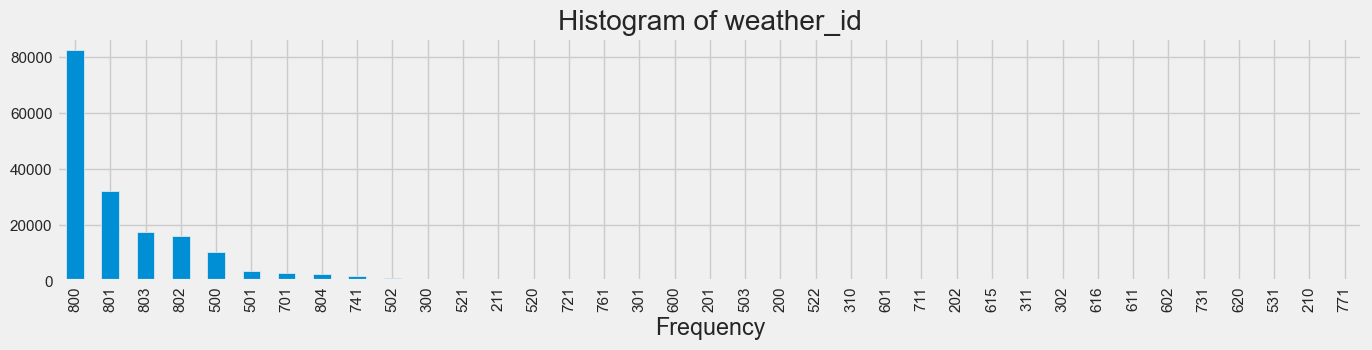

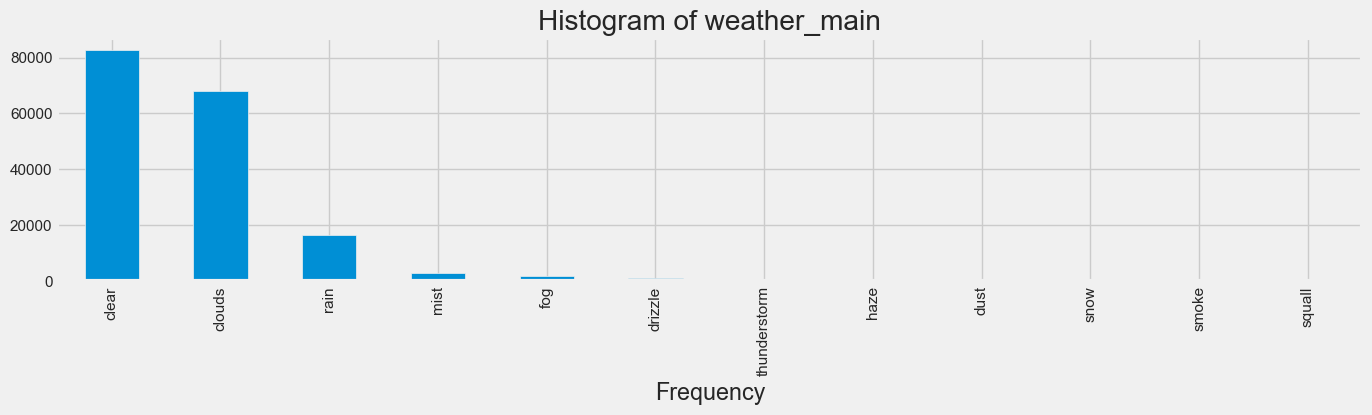

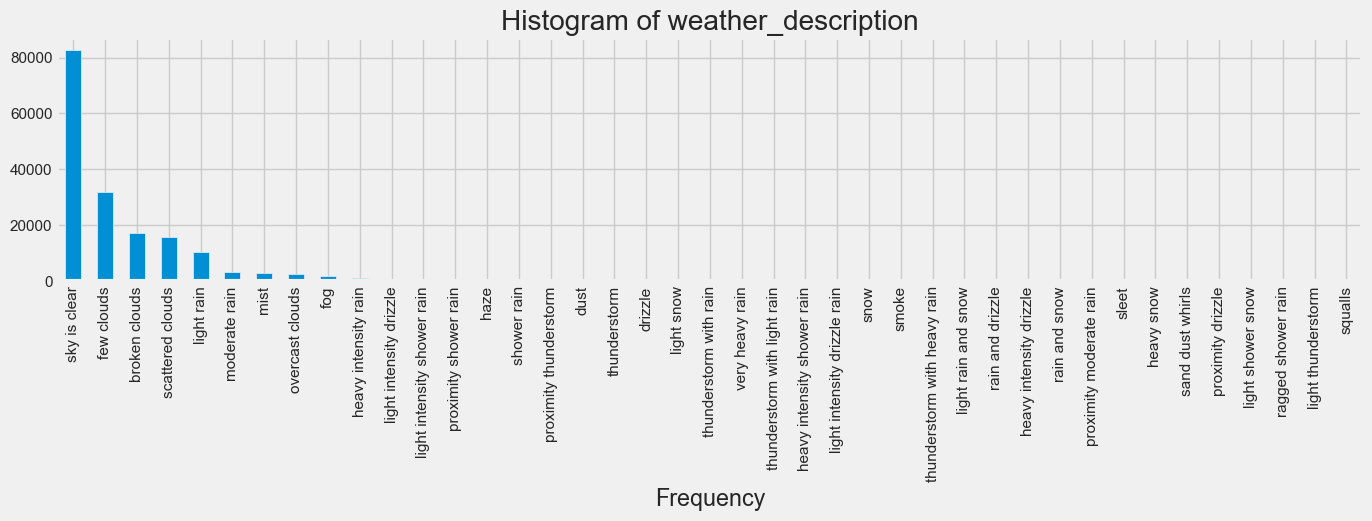

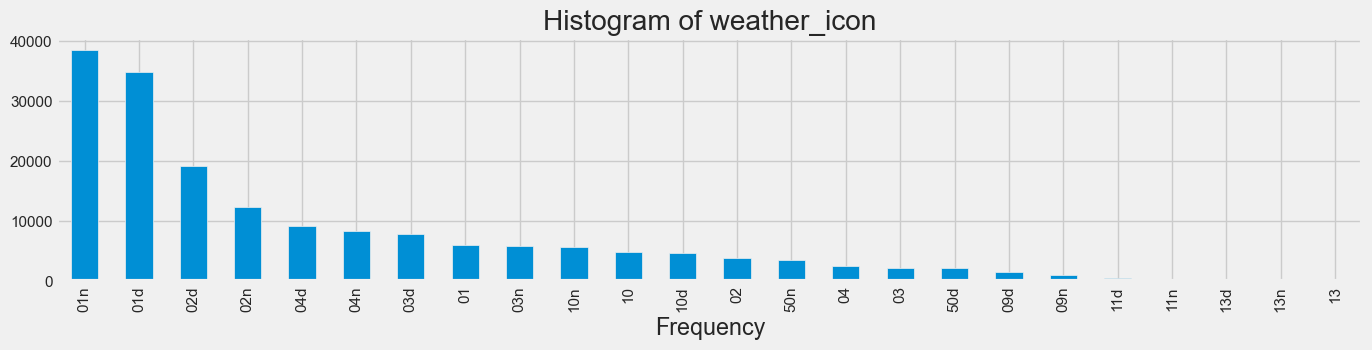

In [168]:
plot_histograms(weather_df, columns=['weather_id', 'weather_main', 'weather_description', 'weather_icon'], titles=None)

Examining the catagorical columns, we find that that they all have different numbers of unique values, but follow similar frequency distributions. In deciding which columns to drop, it would make sense that ***weather_icon*** and ***weather_id*** should go. It is unclear what these columns mean, and if deemed important in the forecasting model, may result in dependance on a feature that is not understood. **Therefore, we choose to drop _weather_icon_ and _weather_id_.**

Moving forward, we are left with ***weather_description***, and ***weather_main***. Because they convey largely the same information, I will just use one of them. In picking between the two variables, there are a few things we must consider.

* ***Descriptiveness*** - It is evident that _weather_description_ is much more comprehensive in its descriptions than _weather_main_. This will allow us to gain more insights from the variable.

* ***Class Distribution*** - Although neither variables have even class distributions, it is reasonable to say that _weather_main_ has less class imbalance than _weather_description_. This would be potentially beneficial in greating a more generalized model.

* ***Redundancy*** - Many of the features of the _weather_main_ could be described by other columns in the dataframe. For example, the _'rain'_ catagory is easily inferred through other variables such as _'rain_1h'_. The more detailed descriptions in _weather_description_ may provide more contect to the model and lead to less redundancy.

For the reasons listed above, we will decide to keep ***weather_description*** as one of our model paramters.

In [169]:
# Listing catagorical columns to drop
catagorical_cols_drop = ['weather_id', 'weather_main', 'weather_icon']

# Dropping specified columns
_ = weather_df.drop(columns=catagorical_cols_drop, inplace=True)

#### Formatting DF

Here, we format our dataframe so that each column value corresponds to data within in a particular city. Ensures that we have a unique time index for each one of our data points and that our weather data can be joined to our energy dataset.

In [170]:
# Intitializing dataframe array
dataframes = []

# Looping through cities
for city in weather_df['city_name'].unique():

    # Filtering dataframe by city and dropping city_name column
    df = weather_df[weather_df['city_name']==city].copy()
    df.drop(columns = 'city_name', inplace=True)

    # Defining new column names
    new_col_names = [col + '_' + city  for col in df.columns]
    df.columns = new_col_names

    # Appending dataframe to array
    dataframes.append(df)

# Concatenating array of dfs to create new dataframe
format_weather_df = pd.concat(dataframes, axis=1)


Upon completing this, we ensure that there are no missing values by linearly interpolating each column of our formatted dataset.

In [171]:
# Interpolating missing values
format_weather_df.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

## Joining Dataframes

In [172]:
# Checking that energy index equals weather index
energy_df.index.equals(format_weather_df.index)

True

In [173]:
# Merging dataframes on time index
df_joined = format_weather_df.merge(energy_df, on='time')

In [174]:
df_joined.head()

temp_Valencia  temp_min_Valencia  \
time                                                          
2014-12-31 23:00:00+00:00        270.475            270.475   
2015-01-01 00:00:00+00:00        270.475            270.475   
2015-01-01 01:00:00+00:00        269.686            269.686   
2015-01-01 02:00:00+00:00        269.686            269.686   
2015-01-01 03:00:00+00:00        269.686            269.686   

                           temp_max_Valencia  pressure_Valencia  \
time                                                              
2014-12-31 23:00:00+00:00            270.475             1001.0   
2015-01-01 00:00:00+00:00            270.475             1001.0   
2015-01-01 01:00:00+00:00            269.686             1002.0   
2015-01-01 02:00:00+00:00            269.686             1002.0   
2015-01-01 03:00:00+00:00            269.686             1002.0   

                           humidity_Valencia  wind_speed_Valencia  \
time                                                                
2014-12-31 23:00:00+00:00                 77                  1.0   
2015-01-01 00:00:00+00:00                 77                  1.0   
2015-01-01 01:00:00+00:00                 78                  0.0   
2015-01-01 02:00:00+00:00                 78                  0.0   
2015-01-01 03:00:00+00:00                 78                  0.0   

                           wind_deg_Valencia  rain_1h_Valencia  \
time                                                             
2014-12-31 23:00:00+00:00                 62               0.0   
2015-01-01 00:00:00+00:00                 62               0.0   
2015-01-01 01:00:00+00:00                 23               0.0   
2015-01-01 02:00:00+00:00                 23               0.0   
2015-01-01 03:00:00+00:00                 23               0.0   

                           snow_3h_Valencia  clouds_all_Valencia  \
time                                                               
2014-12-31 23:00:00+00:00               0.0                    0   
2015-01-01 00:00:00+00:00               0.0                    0   
2015-01-01 01:00:00+00:00               0.0                    0   
2015-01-01 02:00:00+00:00               0.0                    0   
2015-01-01 03:00:00+00:00               0.0                    0   

                          weather_description_Valencia  temp_Madrid  \
time                                                                  
2014-12-31 23:00:00+00:00                 sky is clear      267.325   
2015-01-01 00:00:00+00:00                 sky is clear      267.325   
2015-01-01 01:00:00+00:00                 sky is clear      266.186   
2015-01-01 02:00:00+00:00                 sky is clear      266.186   
2015-01-01 03:00:00+00:00                 sky is clear      266.186   

                           temp_min_Madrid  temp_max_Madrid  pressure_Madrid  \
time                                                                           
2014-12-31 23:00:00+00:00          267.325          267.325            971.0   
2015-01-01 00:00:00+00:00          267.325          267.325            971.0   
2015-01-01 01:00:00+00:00          266.186          266.186            971.0   
2015-01-01 02:00:00+00:00          266.186          266.186            971.0   
2015-01-01 03:00:00+00:00          266.186          266.186            971.0   

                           humidity_Madrid  wind_speed_Madrid  \
time                                                            
2014-12-31 23:00:00+00:00               63                1.0   
2015-01-01 00:00:00+00:00               63                1.0   
2015-01-01 01:00:00+00:00               64                1.0   
2015-01-01 02:00:00+00:00               64                1.0   
2015-01-01 03:00:00+00:00               64                1.0   

                           wind_deg_Madrid  rain_1h_Madrid  snow_3h_Madrid  \
time                                                                         
2014-12-31 23:00:00+

# Exploration and Analysis

## Price and Load Data Time Series Data

We start by defining a time series plotting function for our time series data. This will be used to visualize how the data evolves over time. Upon the defininition of this function, we plot a number of important variables over the first 4 weeks of operation. These variables are power generated by source, total load, and power prices.

In [175]:
def plot_time_series(data=None, columns=None, title="Time Series Plot", ylabel="Values",
                          subplots=False, start=0, end=None, legend=True, figsize=(15, 5)):
    """
    Plots time series data from a pandas DataFrame or Series.

    Parameters:
    - data (pandas.DataFrame or pandas.Series): Data to be plotted.
    - columns (list or None): Columns to plot from the DataFrame. If None, all columns are plotted.
    - title (str): Title for the plot.
    - ylabel (str): Y-axis label.
    - subplots (bool): If True, plots each column in a separate subplot. Otherwise, plots them on the same axes.
    - start (int): Starting index for slicing the data. Useful for zooming in on a part of the time series.
    - end (int or None): Ending index for slicing the data. Useful for zooming in on a part of the time series.
    - legend (bool): If True, displays the legend.
    - figsize (tuple): Figure size for the plot.

    Returns:
    None. Displays the plot.
    """

    sns.set()  # Set seaborn styling

    if isinstance(data, pd.DataFrame):
        if columns is None:
            columns = data.columns
        
        selected_data = data[columns][start:end]  # Select data based on start and end index
        
        if not selected_data.empty:
            selected_data.plot(subplots=subplots, figsize=figsize)  # Plot selected data
            
    elif isinstance(data, pd.Series):
        data.plot(figsize=figsize)  # Plot Series data
        legend=False
        
    else:
        raise ValueError("Invalid data type. Expected pandas DataFrame or Series.")

    plt.title(title)  # Set title
    plt.xlabel("Time")
    plt.ylabel(ylabel)

    if legend:
        plt.legend()  # Display legend if legend=True

    plt.show()  # Display the plot


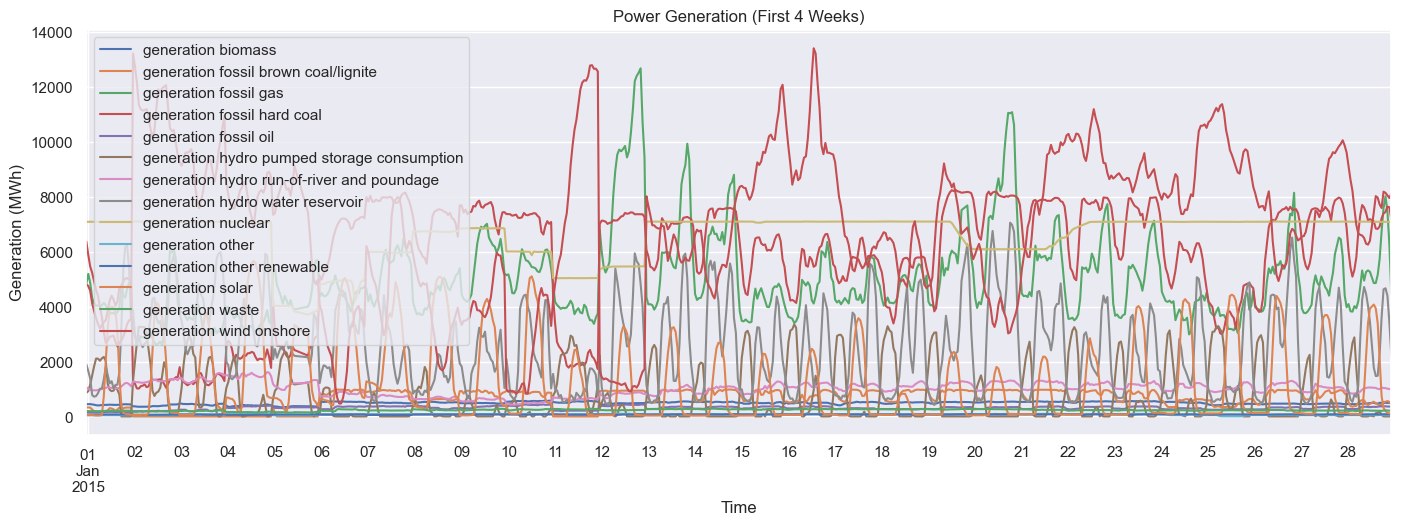

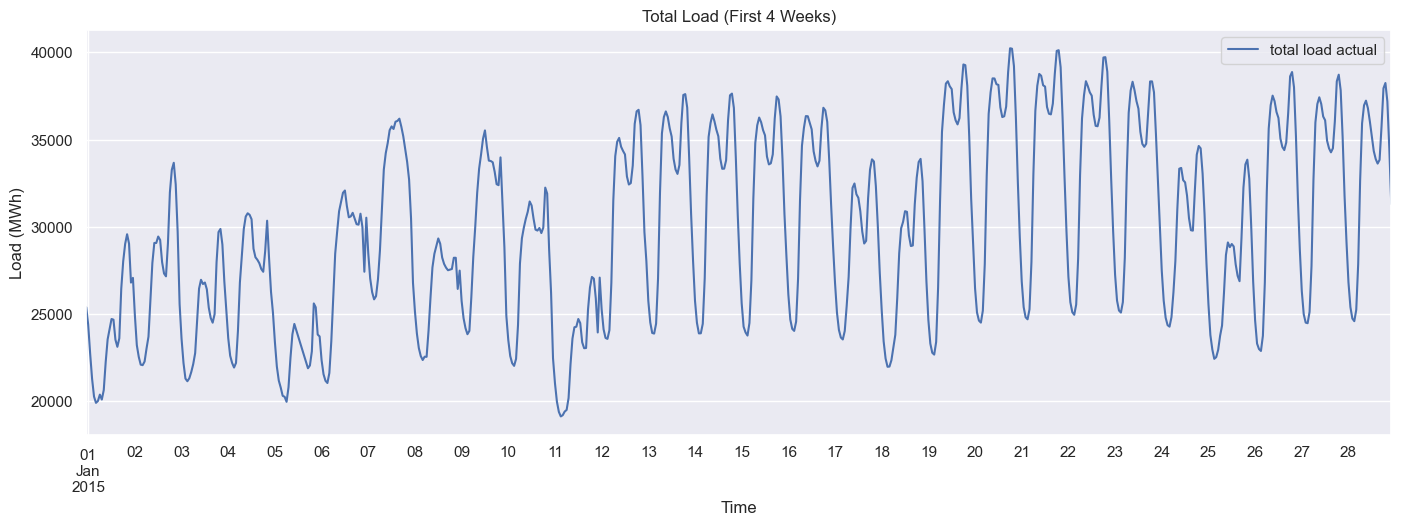

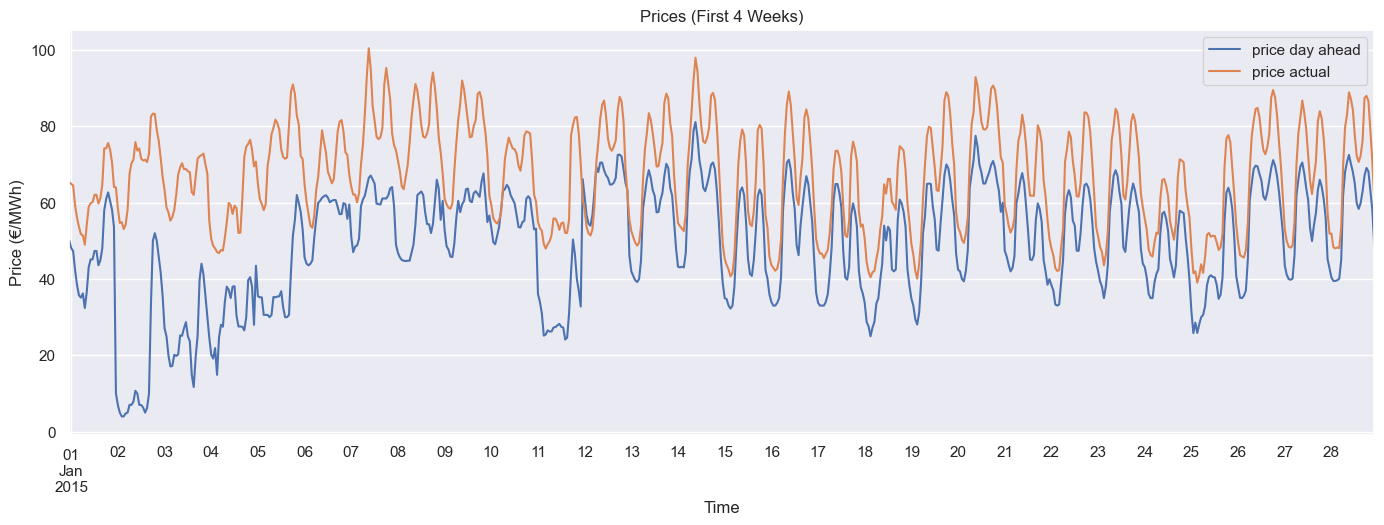

In [176]:
# Defining end date for first 4 weeks
end = 4*7*24

# Plotting relevant characteristics
plot_time_series(energy_df, columns = energy_df.columns[0:14], title='Power Generation (First 4 Weeks)', ylabel="Generation (MWh)", end=end)
plot_time_series(energy_df, columns = energy_df.columns[14], title='Total Load (First 4 Weeks)', ylabel="Load (MWh)", end=end)
plot_time_series(energy_df, columns = energy_df.columns[15:17], title='Prices (First 4 Weeks)', ylabel="Price (€/MWh)", end=end)

From our plotted data, we can observe that our load and price columns have some periodicity. This periodic data will decomposed and analyzed in our subsequent prophet time series analysis. Furthermore, in specifically examining the price data, we see that ***price actual*** and ***price day ahead*** follow very similar trends.

We now examine the price and load data over the entire dataset.

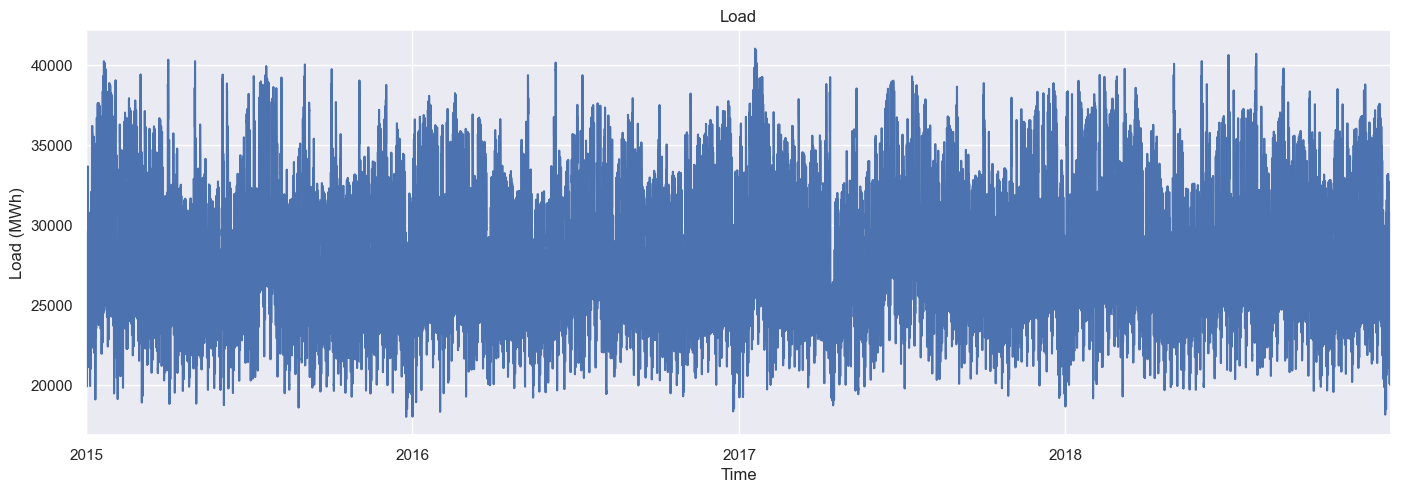

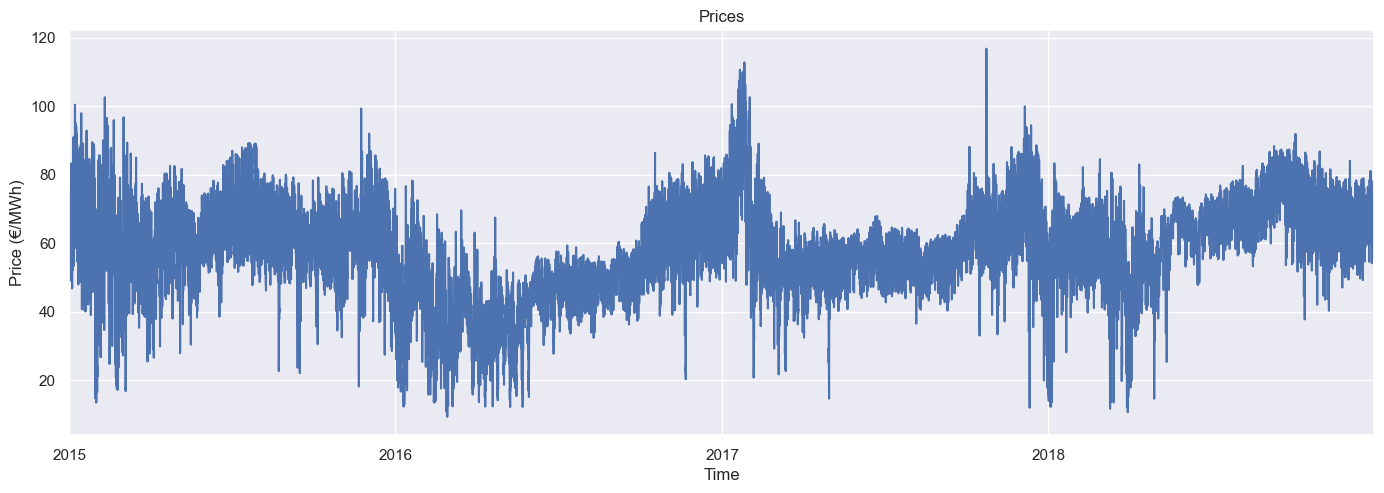

In [177]:
plot_time_series(energy_df['total load actual'], title='Load', ylabel="Load (MWh)")
plot_time_series(energy_df['price actual'], title='Prices', ylabel="Price (€/MWh)")

In comparing the price and load time series data, we can see that load has a much more regular pattern than price. To further analyze our load and price information, we will plot the hourly changes in load and price and examine their volitility.

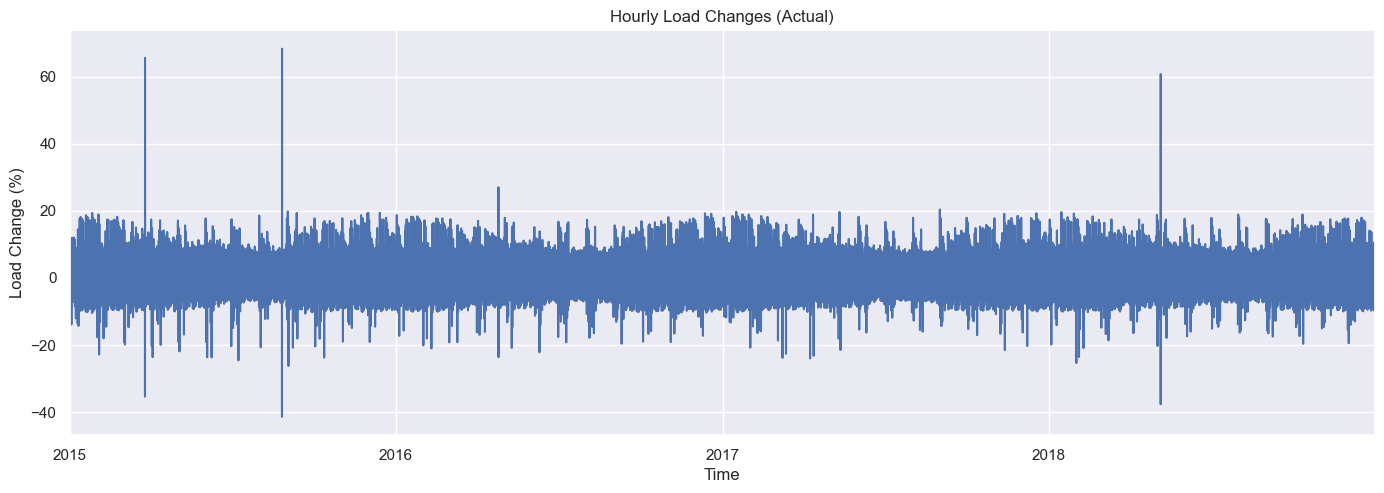

In [178]:
change_in_load = df_joined['total load actual'].pct_change().mul(100)
plot_time_series(data=change_in_load, title='Hourly Load Changes (Actual)', ylabel='Load Change (%)')

From examining the percentage changes in hourly load, we see that it follows a fairly consistent pattern. Apart from a few outliers, there doesn't seem to be huge variations in the load between each hour. I spent some time trying to examine what the large hourly changes were correlated with, but I couldn't find any reasonable explanation. Therefor, I am operating under the assumption that these drastic changes in load are due to blackouts or brownouts.

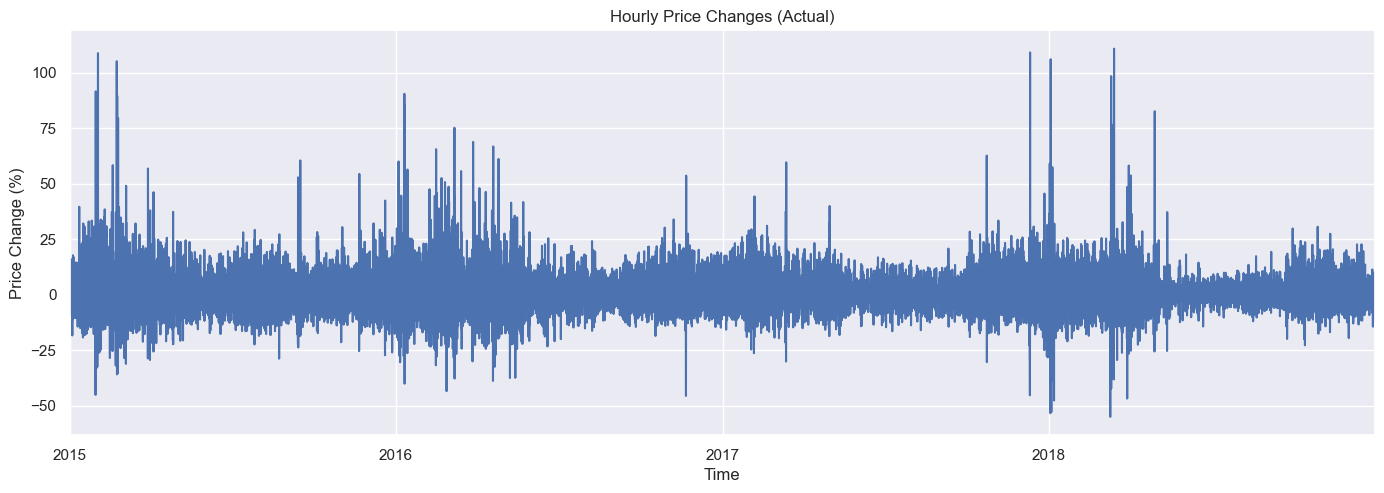

In [179]:
change_in_actual_price = df_joined['price actual'].pct_change().mul(100)
plot_time_series(data=change_in_actual_price, title='Hourly Price Changes (Actual)', ylabel='Price Change (%)')

Changes in price seem to be more volatile than changes in load. They do not appear to follow a consistent pattern have a lot more outliers. From this observation, we can anticipate that predicting price will be more challenging than predicting load.

In [180]:
print('Standard deviation of change in load: {:.2f}'.format(change_in_load.std()))
print('Standard deviation of change actual prices: {:.2f}'.format(change_in_actual_price.std()))

Standard deviation of change in load: 5.14
Standard deviation of change actual prices: 7.50


We see that the stard deviation of price changes is higher than that of load changes. This aligns with what we observed in the figures above. Now, we examine the distribution of prices and load by using a violin plot.

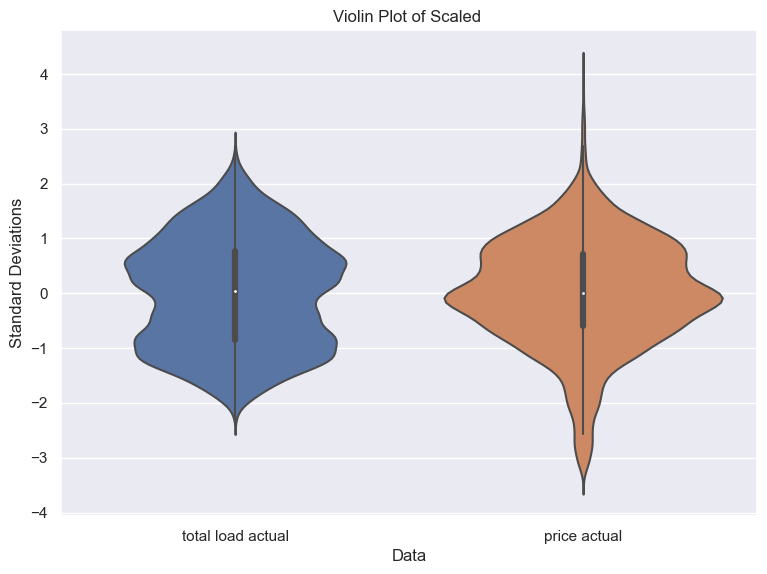

In [181]:
# Normalizing columns
normalized_energy_df = (energy_df - energy_df.mean()) / energy_df.std()

# Combine scaled data into a single column for plotting
scaled_data = pd.melt(normalized_energy_df[['total load actual', 'price actual']],
                      var_name='Data', 
                      value_name='Standard Deviations'
                      )

# Create the violin plot using Seaborn
plt.figure(figsize=(8, 6))
sns.violinplot(x='Data', y='Standard Deviations', data=scaled_data)
plt.title('Violin Plot of Scaled ')
plt.show()


From the violin plot above, we see that there is substantially more spread in price than load. This further indicates that the price data is more sporadic will be harder to predict using ML.

## Correlations

To start, we create a heatmap of pearson correlations.

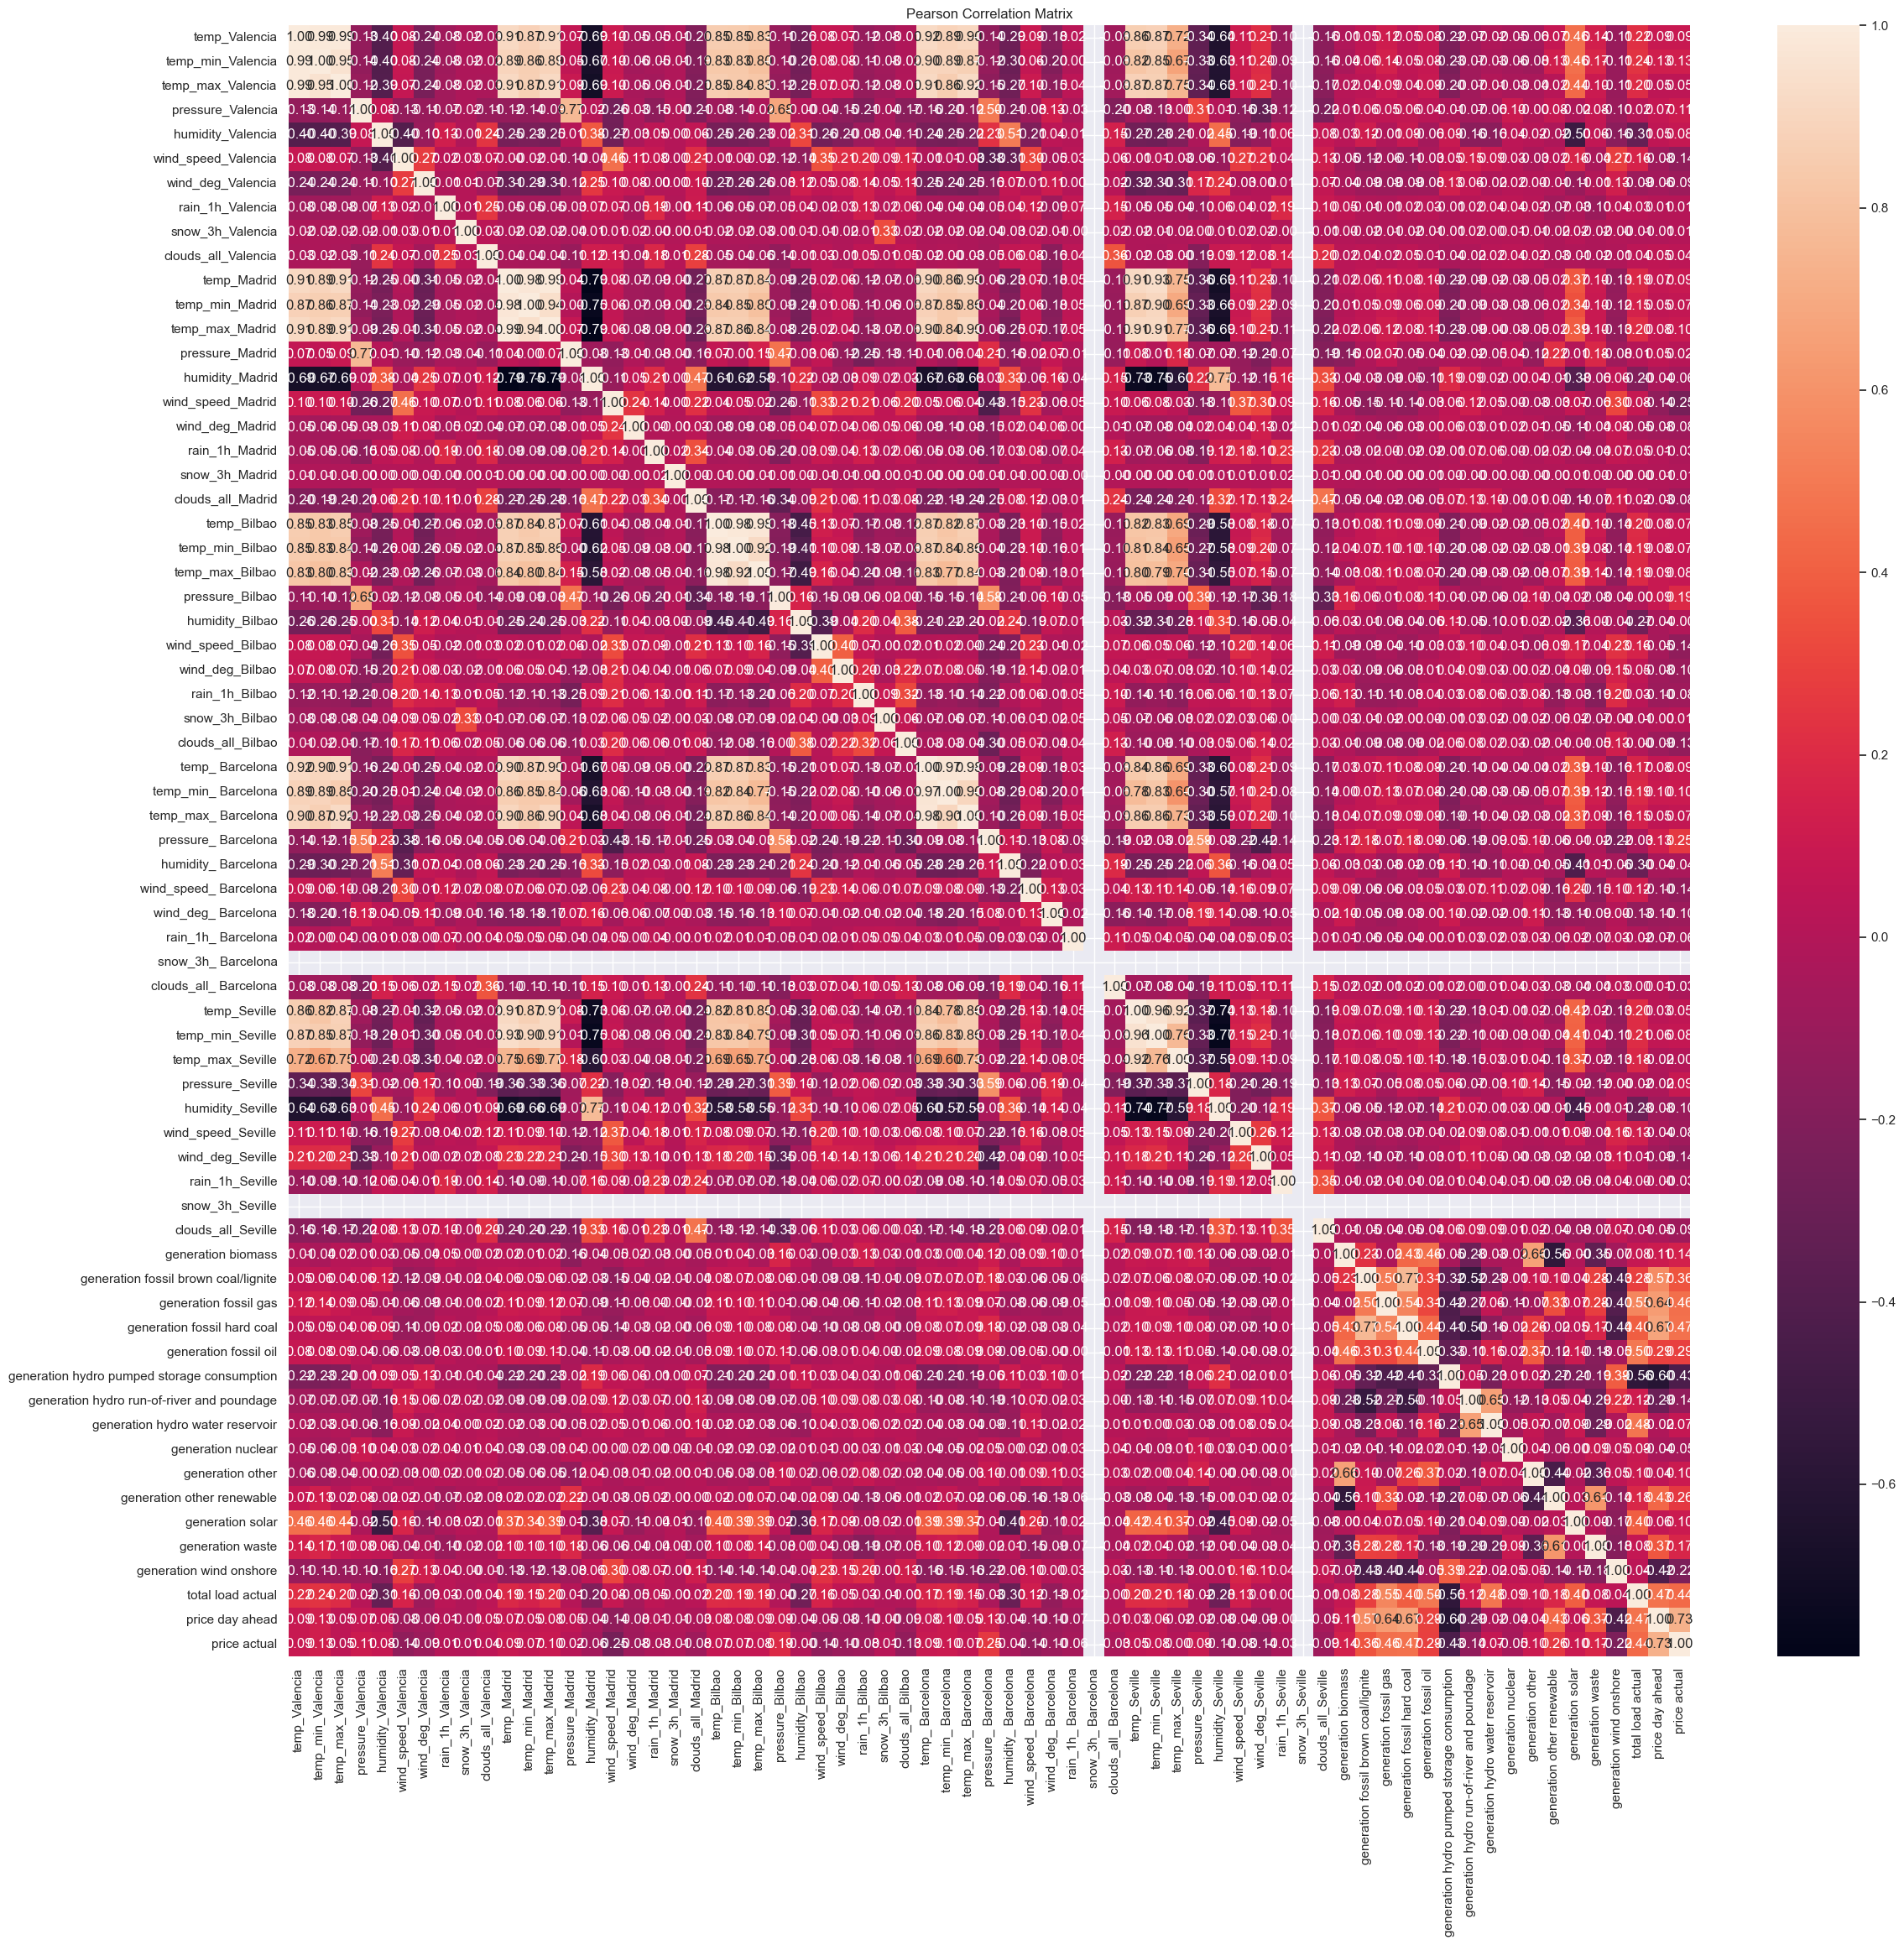

In [182]:
# Specifying catagorical columns to drop
columns_to_drop = [col for col in df_joined.columns if col.startswith('weather_description')]

# Drop the columns
df_joined_numerical = df_joined.drop(columns=columns_to_drop)

# Plot Pearson correlation matrix
correlations = df_joined_numerical.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

While it is difficult to gather insights from this correlation matrix, we can see that there are a number of columns which are highly correlated. To examine information about price and load further, we will look at the features which most correlate to price and load.

In [183]:
# Find the correlations between the electricity price and the rest of the features

correlations = df_joined_numerical.corr(method='pearson')
print("Top Correlations With Electricty Prices:\n")
print(correlations['price actual'].sort_values(ascending=False))

Top Correlations With Electricty Prices:

price actual                                   1.000000
price day ahead                                0.732155
generation fossil hard coal                    0.465637
generation fossil gas                          0.461452
total load actual                              0.435253
                                                 ...   
generation wind onshore                       -0.220497
wind_speed_Madrid                             -0.245861
generation hydro pumped storage consumption   -0.426196
snow_3h_ Barcelona                                  NaN
snow_3h_Seville                                     NaN
Name: price actual, Length: 67, dtype: float64


In [184]:
# Find the correlations between the load and the rest of the features

print("Top Feature Correlations With Load:\n")
print(correlations['total load actual'].sort_values(ascending=False))

Top Feature Correlations With Load:

total load actual                              1.000000
generation fossil gas                          0.548986
generation fossil oil                          0.496139
generation hydro water reservoir               0.479491
price day ahead                                0.474273
                                                 ...   
humidity_ Barcelona                           -0.300901
humidity_Valencia                             -0.314687
generation hydro pumped storage consumption   -0.562934
snow_3h_ Barcelona                                  NaN
snow_3h_Seville                                     NaN
Name: total load actual, Length: 67, dtype: float64


Apart from ***price actual*** and ***total load actual*** correlating with one another (with a value of ~0.44) we also see that fossil fuel generation features appear to correlate with both of these features as well. Interestingly, we find that ***generation hydro pumped storage consumption*** is most negatively correlated with both ***price actual*** and ***total load actual***

As another observation, we see that ***price day ahead*** is the feature most correlated with ***price actual***. In the future, it would be interesting to examine how ML predictions will fare without this information.

Because **snow_3h_Barcelona** and ***snow_3h_Seville*** both have NaN correlations with both price and load (I doubt its snowed in these cities over the timeframe we have), we will drop these columns. 

In [185]:
# Dropping columns
df_joined.drop(columns=['snow_3h_ Barcelona', 'snow_3h_Seville'], inplace=True)

# Time Series Forecasting - Prophet

## Load Forecasting

Facebook's Prophet proves advantageous in predicting electricity loads due to its capability to accommodate the intricate time series patterns inherent in electricity consumption. By employing additive modeling and Fourier decomposition, Prophet adeptly captures daily, weekly, and yearly seasonality in electricity load fluctuations, enhancing the accuracy of demand forecasts. The tool's automated outlier detection further enhances forecast precision by identifying irregular data points. Additionally, Prophet's capacity to quantify uncertainty intervals offers decision-makers a clear understanding of forecast reliability. 

It's important to note that the forecasting model described here solely relies on dates and their corresponding loads as inputs, omitting patterns related to generation, weather, or external conditions. While this omission could impact the model's performance, it still establishes a robust foundation for predicting electric loads and discerning trends.

In [211]:
# Getting load information from df_joined
prophet_df_load = df_joined.reset_index()[['time', 'total load actual']].rename(columns={'time': 'ds', 'total load actual': 'y'})

# Localizing time
prophet_df_load['ds'] = prophet_df_load['ds'].dt.tz_localize(None)

In [187]:
# Splitting into training and validation datasets
split_date = '2018-01-01'
prophet_load_train = prophet_df_load.loc[prophet_df_load.ds  < split_date].copy()
prophet_load_val = prophet_df_load.loc[prophet_df_load.ds  >= split_date].copy()

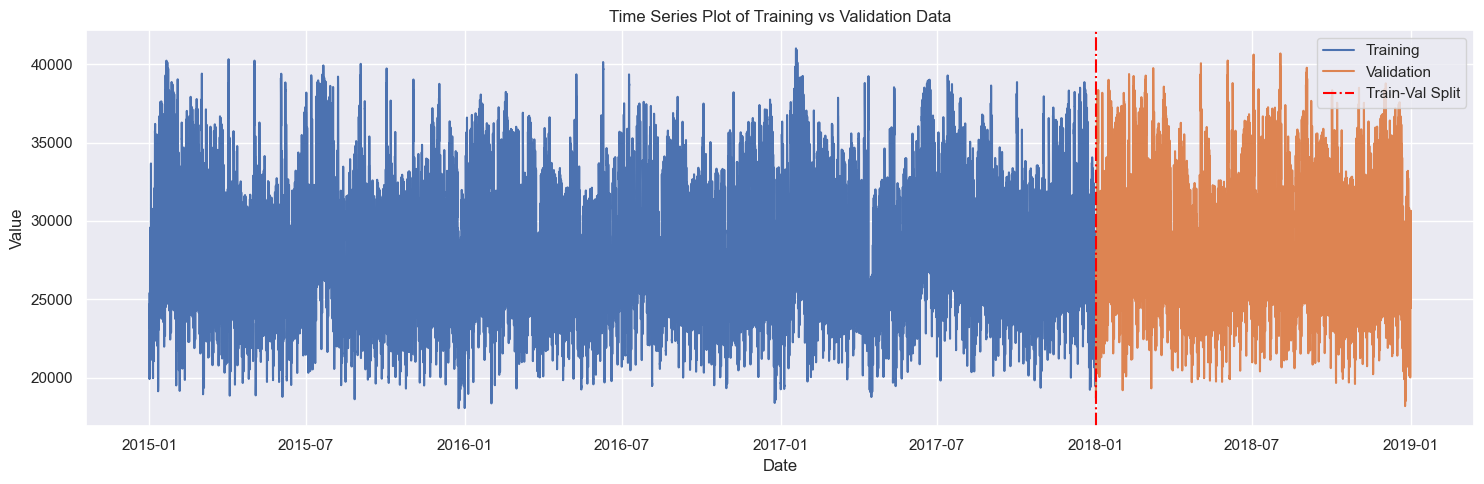

In [188]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 5))  # Adjust the size as needed

# Plot data
ax.plot(prophet_load_train.ds, prophet_load_train.y, label='Training', linestyle='-')
ax.plot(prophet_load_val.ds, prophet_load_val.y, label='Validation', linestyle='-')

# Highlight the split between training and validation with a vertical line
ax.axvline(pd.to_datetime(split_date), color='red', linestyle='-.', label='Train-Val Split')

# Add titles and labels
ax.set_title('Time Series Plot of Training vs Validation Data')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()  # Display the legend

plt.tight_layout()
plt.show()


In [189]:
# Creating Prophet model with 95% confidence interval
m_load = Prophet(interval_width=0.95)

# Fitting model
m_load.fit(prophet_load_train)

# Using fitted model to create forecast
prophet_load_forecast = m_load.predict(df=prophet_load_val)

17:47:49 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1] done processing


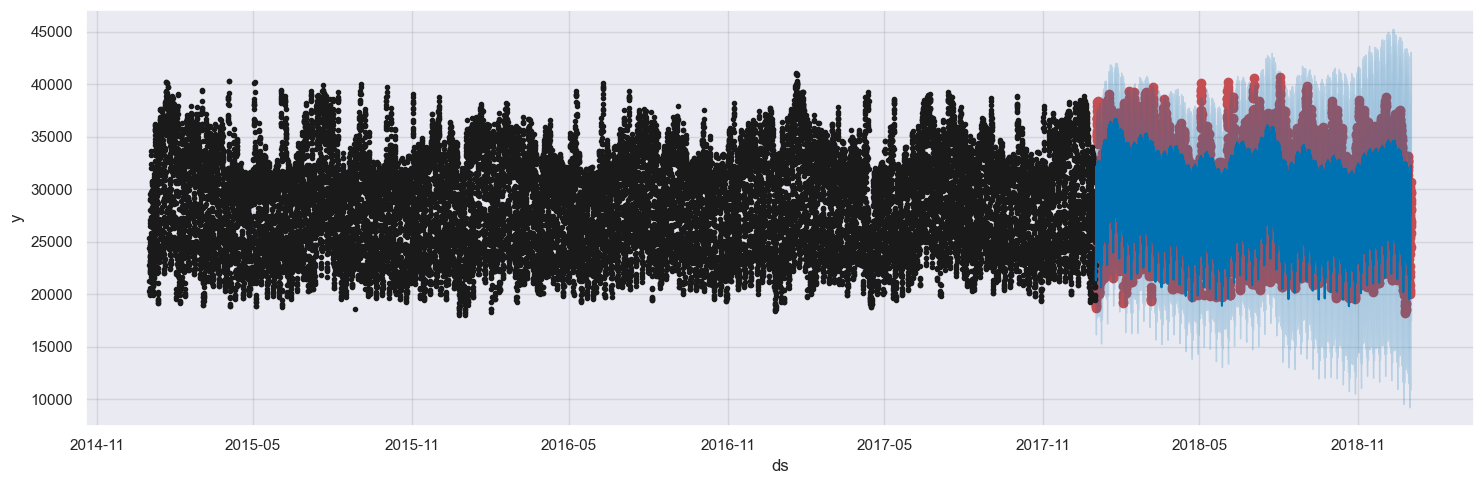

In [192]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(prophet_load_val.ds, prophet_load_val.y, color='r')
fig = m_load.plot(prophet_load_forecast, ax=ax)
plt.show()

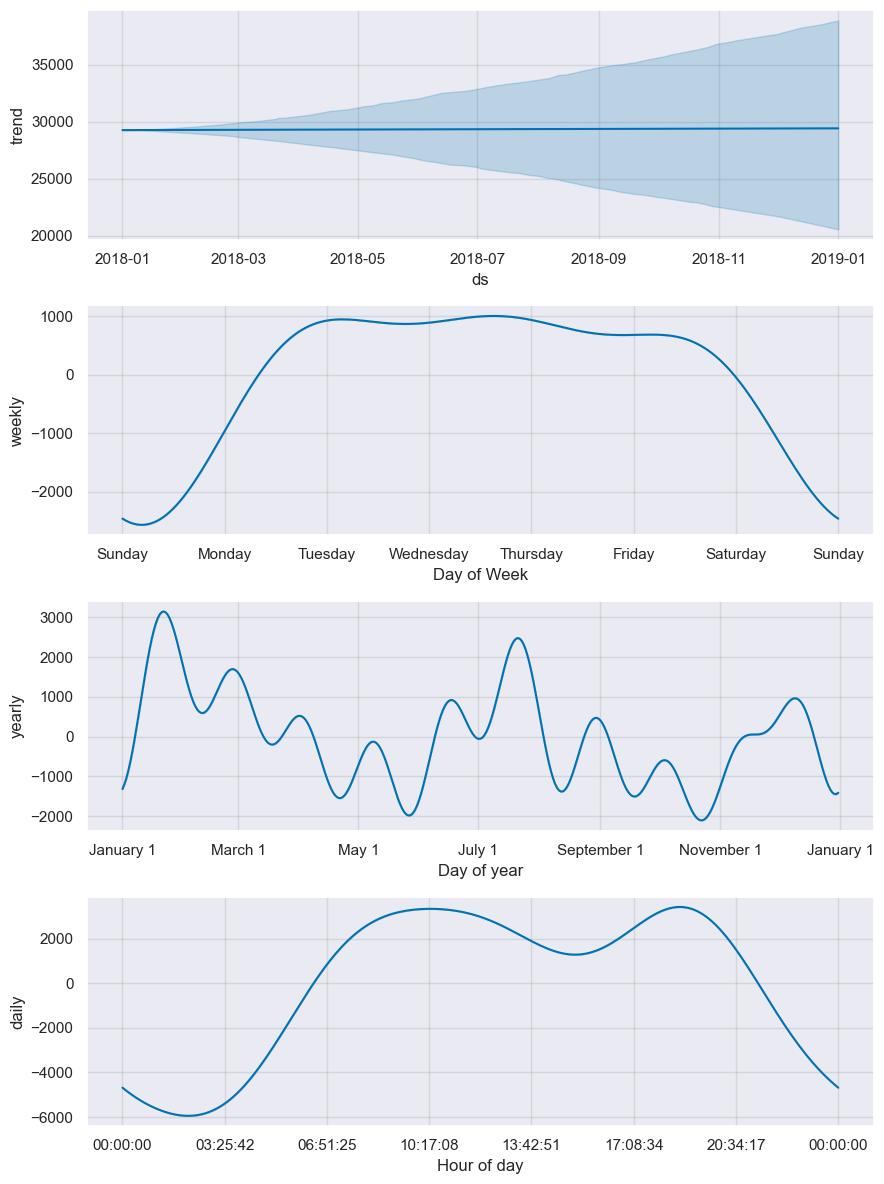

In [191]:
fig = m_load.plot_components(prophet_load_forecast)
plt.show()

Upon dissecting seasonal trends, several intriguing observations come to light. Initially, it becomes evident that the forecast maintains a relatively consistent pattern without any pronounced linear trend beneath it. Notably, there is a substantial reduction in electricity usage during weekends, aligning with expectations. Additionally, the peaks in electricity consumption during summer and winter stand out prominently.

Another interesting aspect of the component decomposition is the midday decline in load. Unlike many Western cultures, Spain incorporates a _siesta_, a break typically spanning from 2 pm to 5 pm, into its workday. This temporal frame closely corresponds to the dip evident in the component decomposition.

To gain a deeper understanding of the time series forecast, we will now delve into shorter forecasting intervals: one month and one week.

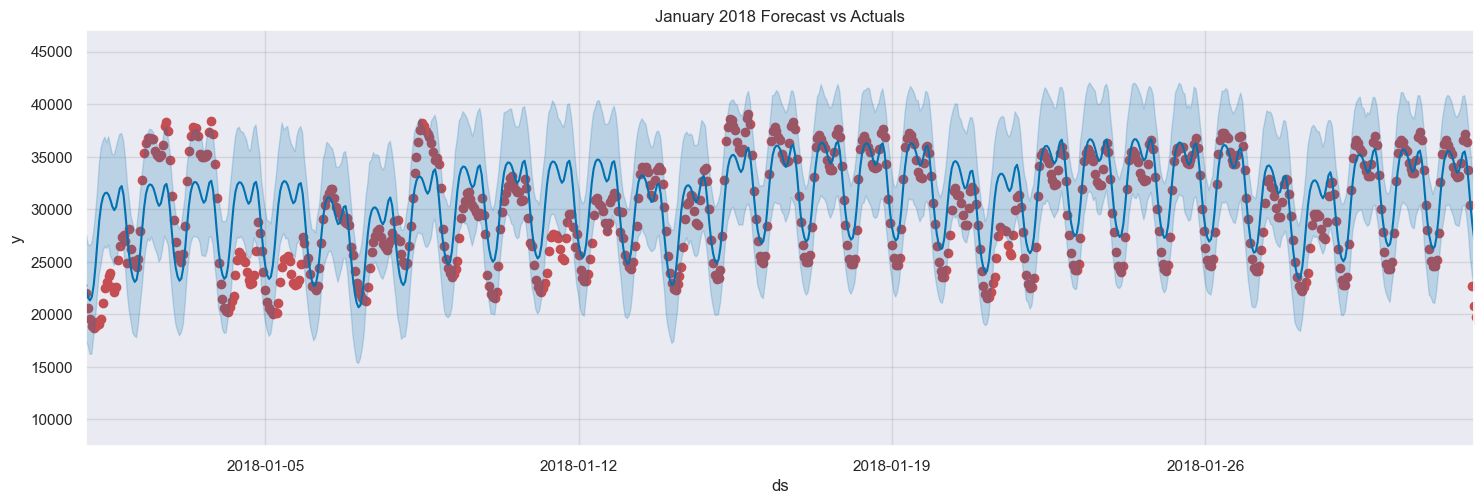

In [193]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(prophet_load_val.ds, prophet_load_val.y , color='r')
fig = m_load.plot(prophet_load_forecast, ax=ax)
ax.set_xbound(lower=pd.to_datetime('01-01-2018'),
              upper=pd.to_datetime('02-01-2018'))
plot = plt.title('January 2018 Forecast vs Actuals')
plt.show()

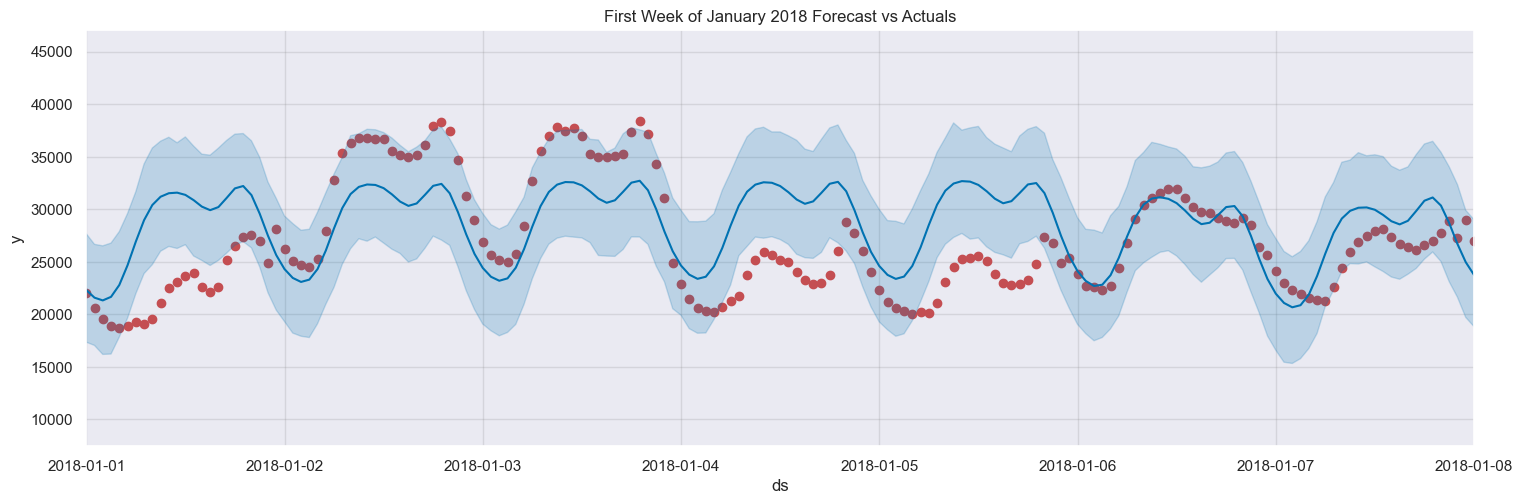

In [212]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(prophet_load_val.ds, prophet_load_val.y , color='r')
fig = m_load.plot(prophet_load_forecast, ax=ax)
ax.set_xbound(lower=pd.to_datetime('01-01-2018'),
              upper=pd.to_datetime('01-08-2018'))
plot = plt.title('First Week of January 2018 Forecast vs Actuals')
plt.show()

#### Error Metrics

In [195]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [214]:
prophet_load_rmse = mean_squared_error(y_true=prophet_load_val.y,
                                      y_pred=prophet_load_forecast.yhat,
                                      squared=False)

propher_load_mae = mean_absolute_error(y_true=prophet_load_val.y,
                                 y_pred=prophet_load_forecast.yhat)

prophet_load_mape = mean_absolute_percentage_error(y_true=prophet_load_val.y,
                                                  y_pred=prophet_load_forecast.yhat)


print(f'The RMSE is: {prophet_load_rmse:.2f}')
print(f'The MAE is: {propher_load_mae:.2f}')
print(f"The MAPE is: {prophet_load_mape:.2f}%")

The RMSE is: 2779.74
The MAE is: 2103.00
The MAPE is: 7.42%


Observing the error metrics, we see that our ***mean absolute percentage error*** is relatively low at $7.42\%$. This shows that our Prophet model is a competent predictor of electric load. This makes sense given our previous oberservations of the ***total load*** time series. Because of its strong seasonal dependance, Prophet can make accurate predictions based on past data.

## Price Forecasting

We now dive into price forecasting using Prophet. Observing the time series trends associated with price, we see that it is much more sporadic than load and has less obvious seasonality associated with it. This is likely due to external data which we do not have available, such as fuel prices. That being said, we will look into forecasting price using Prophet to observe some of these seasonal trends.

In [197]:
# Getting load information from df_joined
prophet_df_price = df_joined.reset_index()[['time', 'price actual']].rename(columns={'time': 'ds', 'price actual': 'y'})

# Localizing time
prophet_df_price['ds'] = prophet_df_price['ds'].dt.tz_localize(None)

In [198]:
# Splitting into training and validation datasets
split_date = '2018-01-01'
prophet_price_train = prophet_df_price.loc[prophet_df_price.ds < split_date].copy()
prophet_price_val = prophet_df_price.loc[prophet_df_price.ds >= split_date].copy()

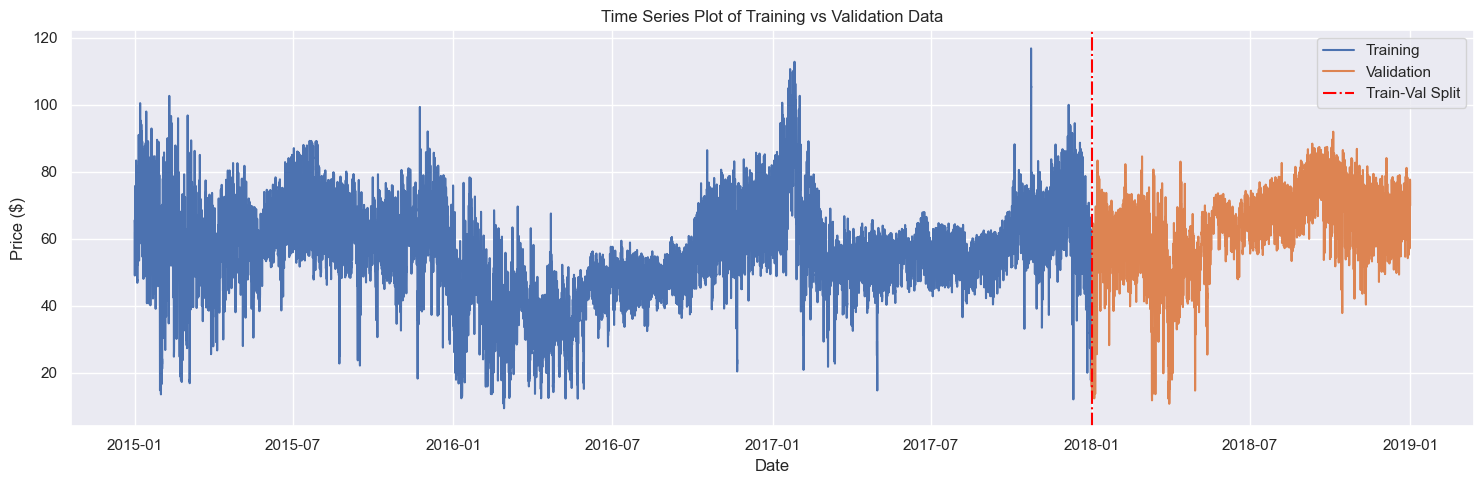

In [199]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 5))  # Adjust the size as needed

# Plot data
ax.plot(prophet_price_train.ds, prophet_price_train.y, label='Training', linestyle='-')
ax.plot(prophet_price_val.ds, prophet_price_val.y, label='Validation', linestyle='-')

# Highlight the split between training and validation with a vertical line
ax.axvline(pd.to_datetime(split_date), color='red', linestyle='-.', label='Train-Val Split')

# Add titles and labels
ax.set_title('Time Series Plot of Training vs Validation Data')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.legend()  # Display the legend

plt.tight_layout()
plt.show()

In [200]:
# Creating Prophet model with 95% confidence interval
m_price = Prophet(interval_width=0.95)

# Fitting model
m_price.fit(prophet_price_train)

# Using fitted model to create forecast
prophet_price_forecast = m_price.predict(df=prophet_load_val)

17:48:10 - cmdstanpy - INFO - Chain [1] start processing
17:48:42 - cmdstanpy - INFO - Chain [1] done processing


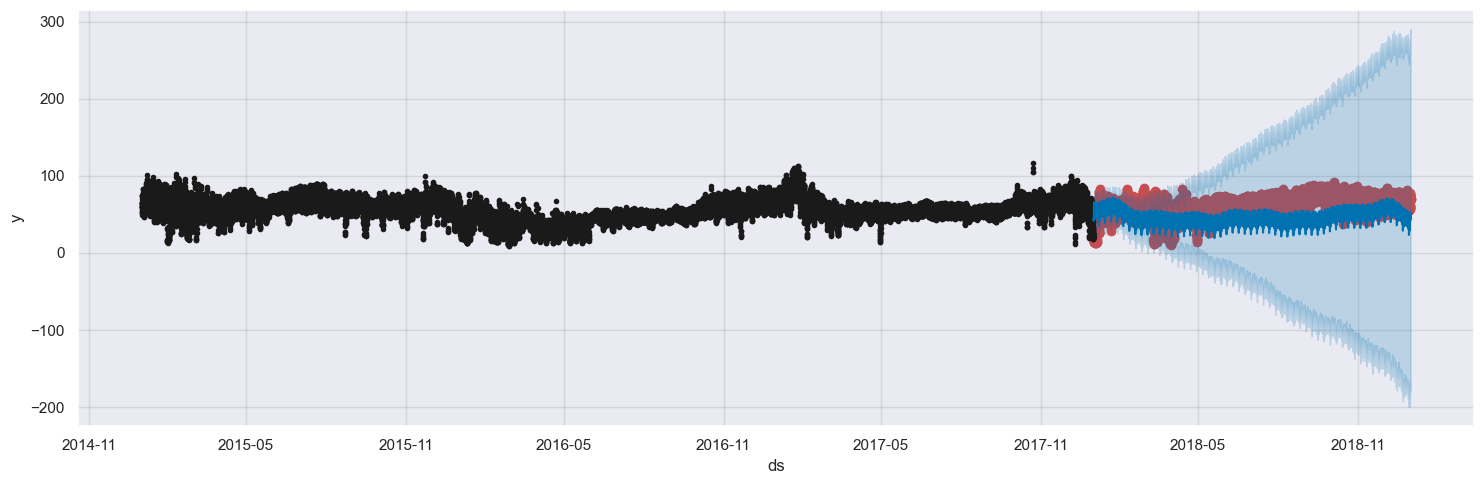

In [203]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(prophet_price_val.ds, prophet_price_val.y, color='r')
fig = m_price.plot(prophet_price_forecast, ax=ax)
plt.show()

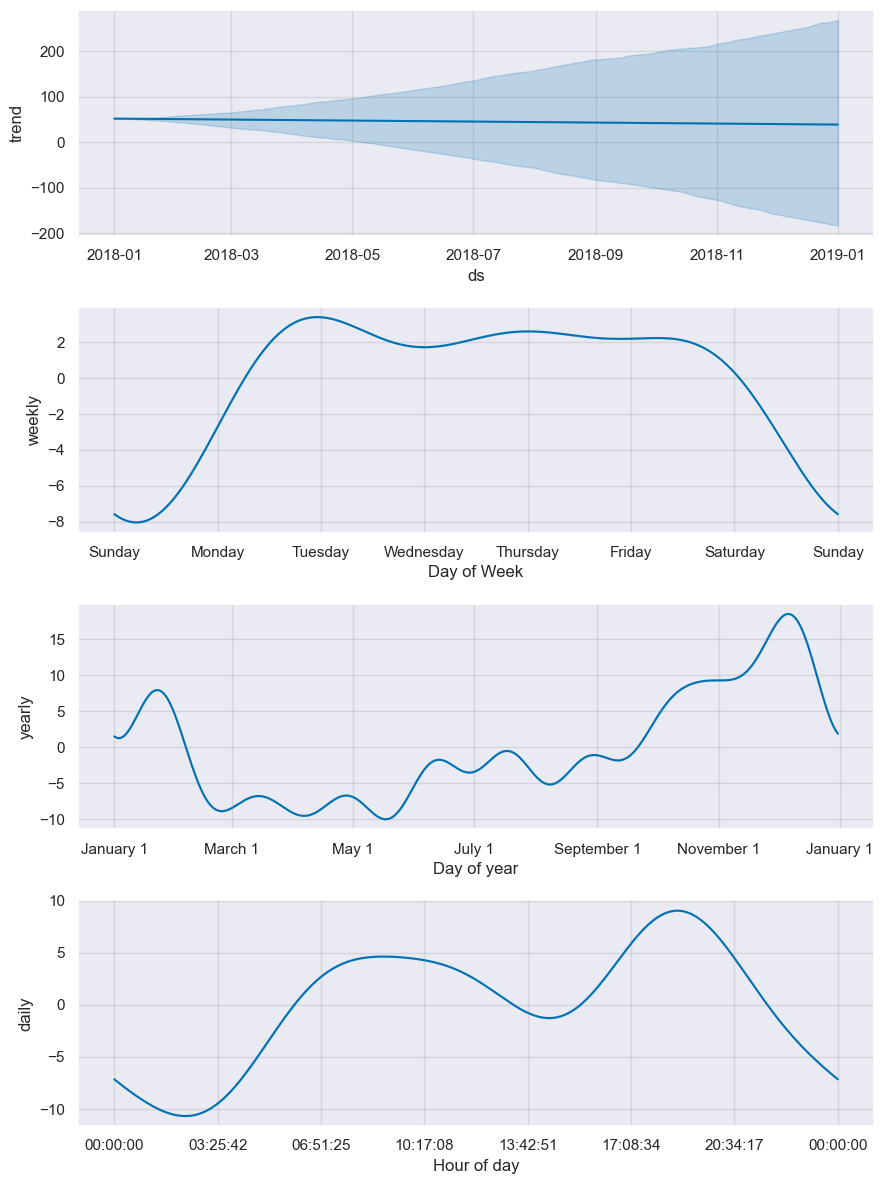

In [202]:
fig = m_price.plot_components(prophet_price_forecast)
plt.show()

Observing the seasonality of ***price actual***, we see many of the same trends as in ***total load actual***. One notable difference however is that we see much less of a peak in the summer. The primary peak in price happens in the late fall/ early winter and otherwise remains relatively constant throughout the year.

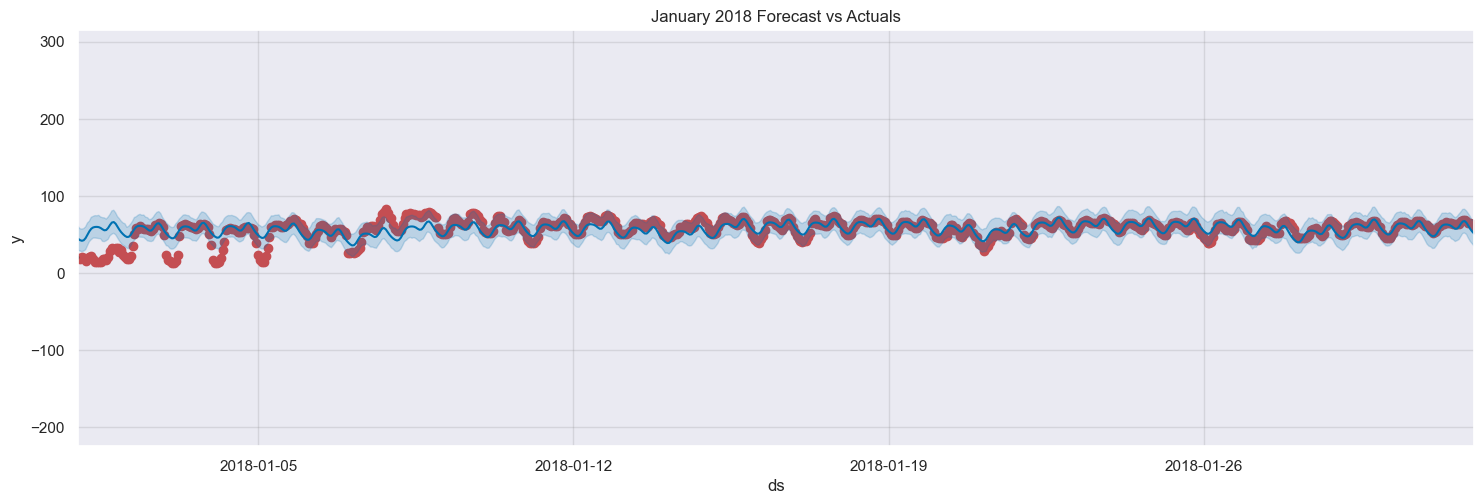

In [204]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(prophet_price_val.ds, prophet_price_val.y , color='r')
fig = m_price.plot(prophet_price_forecast, ax=ax)
ax.set_xbound(lower=pd.to_datetime('01-01-2018'),
              upper=pd.to_datetime('02-01-2018'))
plot = plt.title('January 2018 Forecast vs Actuals')
plt.show()

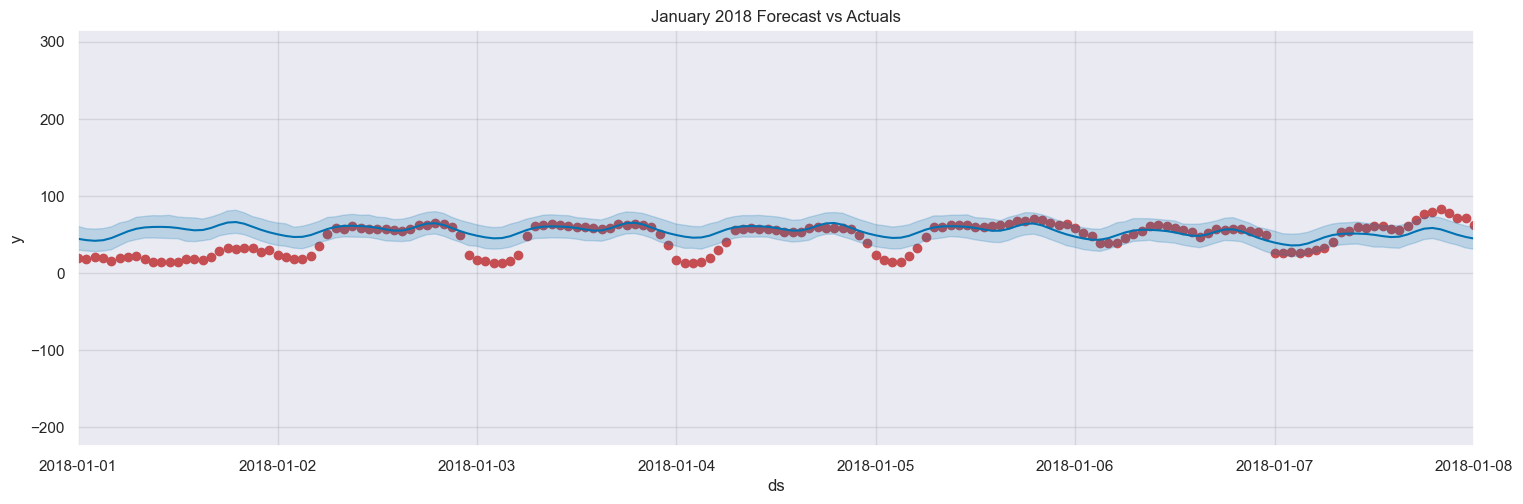

In [205]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(prophet_price_val.ds, prophet_price_val.y , color='r')
fig = m_price.plot(prophet_price_forecast, ax=ax)
ax.set_xbound(lower=pd.to_datetime('01-01-2018'),
              upper=pd.to_datetime('01-08-2018'))
plot = plt.title('January 2018 Forecast vs Actuals')
plt.show()

In [206]:
prophet_price_rmse = mean_squared_error(y_true=prophet_price_val.y,
                                        y_pred=prophet_price_forecast.yhat,
                                        squared=False)

prophet_price_mae = mean_absolute_error(y_true=prophet_price_val.y,
                                        y_pred=prophet_price_forecast.yhat)

prophet_price_mape = mean_absolute_percentage_error(y_true=prophet_price_val.y,
                                                    y_pred=prophet_price_forecast.yhat)

print(f'The RMSE is: {prophet_price_rmse:.2f}')
print(f'The MAE is: {prophet_price_mae:.2f}')
print(f"The RMSE is: {prophet_price_mape:.2f}%")

The RMSE is: 21.44
The MAE is: 18.86
The RMSE is: 30.26%


Observing the error metrics, we see that our ***mean absolute percentage error*** for price forecasting is much higher at with a value of $30.26\%$. This shows that our Prophet model is not as reliable at predicting price as it is load. This begs the need for more advanced forecasting methods which account for other explanatory variables.

# Feature Engineering

# Feature Creation

In [207]:
df_ML = df_joined.copy()

df_ML['day_of_week'] = df_ML.index.weekday
# df_ML['day_of_year'] = df_ML.index.dayofyear
df_ML['month'] = df_ML.index.month
df_ML['day_of_month'] = df_ML.index.day
df_ML['hour'] = df_ML.index.hour

In [208]:
df_ML.head()

temp_Valencia  temp_min_Valencia  \
time                                                          
2014-12-31 23:00:00+00:00        270.475            270.475   
2015-01-01 00:00:00+00:00        270.475            270.475   
2015-01-01 01:00:00+00:00        269.686            269.686   
2015-01-01 02:00:00+00:00        269.686            269.686   
2015-01-01 03:00:00+00:00        269.686            269.686   

                           temp_max_Valencia  pressure_Valencia  \
time                                                              
2014-12-31 23:00:00+00:00            270.475             1001.0   
2015-01-01 00:00:00+00:00            270.475             1001.0   
2015-01-01 01:00:00+00:00            269.686             1002.0   
2015-01-01 02:00:00+00:00            269.686             1002.0   
2015-01-01 03:00:00+00:00            269.686             1002.0   

                           humidity_Valencia  wind_speed_Valencia  \
time                                                                
2014-12-31 23:00:00+00:00                 77                  1.0   
2015-01-01 00:00:00+00:00                 77                  1.0   
2015-01-01 01:00:00+00:00                 78                  0.0   
2015-01-01 02:00:00+00:00                 78                  0.0   
2015-01-01 03:00:00+00:00                 78                  0.0   

                           wind_deg_Valencia  rain_1h_Valencia  \
time                                                             
2014-12-31 23:00:00+00:00                 62               0.0   
2015-01-01 00:00:00+00:00                 62               0.0   
2015-01-01 01:00:00+00:00                 23               0.0   
2015-01-01 02:00:00+00:00                 23               0.0   
2015-01-01 03:00:00+00:00                 23               0.0   

                           snow_3h_Valencia  clouds_all_Valencia  \
time                                                               
2014-12-31 23:00:00+00:00               0.0                    0   
2015-01-01 00:00:00+00:00               0.0                    0   
2015-01-01 01:00:00+00:00               0.0                    0   
2015-01-01 02:00:00+00:00               0.0                    0   
2015-01-01 03:00:00+00:00               0.0                    0   

                          weather_description_Valencia  temp_Madrid  \
time                                                                  
2014-12-31 23:00:00+00:00                 sky is clear      267.325   
2015-01-01 00:00:00+00:00                 sky is clear      267.325   
2015-01-01 01:00:00+00:00                 sky is clear      266.186   
2015-01-01 02:00:00+00:00                 sky is clear      266.186   
2015-01-01 03:00:00+00:00                 sky is clear      266.186   

                           temp_min_Madrid  temp_max_Madrid  pressure_Madrid  \
time                                                                           
2014-12-31 23:00:00+00:00          267.325          267.325            971.0   
2015-01-01 00:00:00+00:00          267.325          267.325            971.0   
2015-01-01 01:00:00+00:00          266.186          266.186            971.0   
2015-01-01 02:00:00+00:00          266.186          266.186            971.0   
2015-01-01 03:00:00+00:00          266.186          266.186            971.0   

                           humidity_Madrid  wind_speed_Madrid  \
time                                                            
2014-12-31 23:00:00+00:00               63                1.0   
2015-01-01 00:00:00+00:00               63                1.0   
2015-01-01 01:00:00+00:00               64                1.0   
2015-01-01 02:00:00+00:00               64                1.0   
2015-01-01 03:00:00+00:00               64                1.0   

                           wind_deg_Madrid  rain_1h_Madrid  snow_3h_Madrid  \
time                                                                         
2014-12-31 23:00:00+

In [209]:
# Identify columns starting with 'weather_description'
weather_description_cols = [col for col in df_ML.columns if col.startswith('weather_description')]

# Apply one-hot encoding to the identified columns
df_ML_encoded = pd.get_dummies(df_ML, columns=weather_description_cols, prefix=weather_description_cols)

In [210]:
df_ML_encoded.head()

temp_Valencia  temp_min_Valencia  \
time                                                          
2014-12-31 23:00:00+00:00        270.475            270.475   
2015-01-01 00:00:00+00:00        270.475            270.475   
2015-01-01 01:00:00+00:00        269.686            269.686   
2015-01-01 02:00:00+00:00        269.686            269.686   
2015-01-01 03:00:00+00:00        269.686            269.686   

                           temp_max_Valencia  pressure_Valencia  \
time                                                              
2014-12-31 23:00:00+00:00            270.475             1001.0   
2015-01-01 00:00:00+00:00            270.475             1001.0   
2015-01-01 01:00:00+00:00            269.686             1002.0   
2015-01-01 02:00:00+00:00            269.686             1002.0   
2015-01-01 03:00:00+00:00            269.686             1002.0   

                           humidity_Valencia  wind_speed_Valencia  \
time                                                                
2014-12-31 23:00:00+00:00                 77                  1.0   
2015-01-01 00:00:00+00:00                 77                  1.0   
2015-01-01 01:00:00+00:00                 78                  0.0   
2015-01-01 02:00:00+00:00                 78                  0.0   
2015-01-01 03:00:00+00:00                 78                  0.0   

                           wind_deg_Valencia  rain_1h_Valencia  \
time                                                             
2014-12-31 23:00:00+00:00                 62               0.0   
2015-01-01 00:00:00+00:00                 62               0.0   
2015-01-01 01:00:00+00:00                 23               0.0   
2015-01-01 02:00:00+00:00                 23               0.0   
2015-01-01 03:00:00+00:00                 23               0.0   

                           snow_3h_Valencia  clouds_all_Valencia  temp_Madrid  \
time                                                                            
2014-12-31 23:00:00+00:00               0.0                    0      267.325   
2015-01-01 00:00:00+00:00               0.0                    0      267.325   
2015-01-01 01:00:00+00:00               0.0                    0      266.186   
2015-01-01 02:00:00+00:00               0.0                    0      266.186   
2015-01-01 03:00:00+00:00               0.0                    0      266.186   

                           temp_min_Madrid  temp_max_Madrid  pressure_Madrid  \
time                                                                           
2014-12-31 23:00:00+00:00          267.325          267.325            971.0   
2015-01-01 00:00:00+00:00          267.325          267.325            971.0   
2015-01-01 01:00:00+00:00          266.186          266.186            971.0   
2015-01-01 02:00:00+00:00          266.186          266.186            971.0   
2015-01-01 03:00:00+00:00          266.186          266.186            971.0   

                           humidity_Madrid  wind_speed_Madrid  \
time                                                            
2014-12-31 23:00:00+00:00               63                1.0   
2015-01-01 00:00:00+00:00               63                1.0   
2015-01-01 01:00:00+00:00               64                1.0   
2015-01-01 02:00:00+00:00               64                1.0   
2015-01-01 03:00:00+00:00               64                1.0   

                           wind_deg_Madrid  rain_1h_Madrid  snow_3h_Madrid  \
time                                                                         
2014-12-31 23:00:00+00:00              309             0.0             0.0   
2015-01-01 00:00:00+00:00              309             0.0             0.0   
2015-01-01 01:00:00+00:00              273             0.0             0.0   
2015-01-01 02:00:00+00:00              273             0.0             0.0   
2015-01-01 03:00:00+00:00              273             0.0             0.0   

                           clouds_al

## Feature Selection

In [215]:
print('hi')

hi
